<a href="https://colab.research.google.com/github/krishnarevi/Product_Search_Relevance_Prediction/blob/main/Product_Search_Relevance_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:


import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns
from matplotlib_venn import venn2
import regex as re
from collections import Counter
!pip install nltk 
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
import re
from collections import Counter
from nltk.stem import PorterStemmer 
from wordcloud import WordCloud, STOPWORDS 
from prettytable import PrettyTable
from sklearn.feature_extraction.text import CountVectorizer 
from textblob import TextBlob
from scipy.stats import spearmanr



Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [3]:


# mount g-drive to access datafiles
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [4]:
path= '/content/drive/MyDrive/data'

In [ ]:
# get search queries
query_df = pd.read_csv(path+r"/query.csv", sep='\t')
query_df.head()

,query_id,query,query_class
0,0,salon chair,Massage Chairs
1,1,smart coffee table,Coffee & Cocktail Tables
2,2,dinosaur,Kids Wall Décor
3,3,turquoise pillows,Accent Pillows
4,4,chair and a half recliner,Recliners


In [ ]:
# get products
product_df = pd.read_csv(path+r"/product.csv", sep='\t')
product_df.head()

,product_id,product_name,product_class,category hierarchy,product_description,product_features,rating_count,average_rating,review_count
0,0,solid wood platform bed,Beds,Furniture / Bedroom Furniture / Beds & Headboa...,"good , deep sleep can be quite difficult to ha...",overallwidth-sidetoside:64.7|dsprimaryproducts...,15.0,4.5,15.0
1,1,all-clad 7 qt . slow cooker,Slow Cookers,Kitchen & Tabletop / Small Kitchen Appliances ...,"create delicious slow-cooked meals , from tend...",capacityquarts:7|producttype : slow cooker|pro...,100.0,2.0,98.0
2,2,all-clad electrics 6.5 qt . slow cooker,Slow Cookers,Kitchen & Tabletop / Small Kitchen Appliances ...,prepare home-cooked meals on any schedule with...,features : keep warm setting|capacityquarts:6....,208.0,3.0,181.0
3,3,all-clad all professional tools pizza cutter,"Slicers, Peelers And Graters",Browse By Brand / All-Clad,this original stainless tool was designed to c...,overallwidth-sidetoside:3.5|warrantylength : l...,69.0,4.5,42.0
4,4,baldwin prestige alcott passage knob with roun...,Door Knobs,Home Improvement / Doors & Door Hardware / Doo...,the hardware has a rich heritage of delivering...,compatibledoorthickness:1.375 '' |countryofori...,70.0,5.0,42.0


In [ ]:
# get manually labeled groundtruth lables
label_df = pd.read_csv(path+r"/label.csv", sep='\t')
label_df

,id,query_id,product_id,label
0,0,0,25434,Exact
1,1,0,12088,Irrelevant
2,2,0,42931,Exact
3,3,0,2636,Exact
4,4,0,42923,Exact
...,...,...,...,...
233443,234010,478,15439,Partial
233444,234011,478,451,Partial
233445,234012,478,30764,Irrelevant
233446,234013,478,16796,Partial


In [ ]:
#Checking for null values 
print(product_df.isna().sum())
print(label_df.isna().sum())
print(query_df.isna().sum())

product_id                0
product_name              0
product_class          2852
category hierarchy     1556
product_description    6008
product_features          0
rating_count           9452
average_rating         9452
review_count           9452
dtype: int64
id            0
query_id      0
product_id    0
label         0
dtype: int64
query_id       0
query          0
query_class    6
dtype: int64


In [ ]:
print("shape of label_df is {} ".format(label_df.shape))
print("shape of query_df is {} ".format(query_df.shape))
print("shape of product_df is {} ".format(product_df.shape))

shape of label_df is (233448, 4) 
shape of query_df is (480, 3) 
shape of product_df is (42994, 9) 


###EDA Labels

In [ ]:
label_df['label'].value_counts()

Partial       146633
Irrelevant     61201
Exact          25614
Name: label, dtype: int64

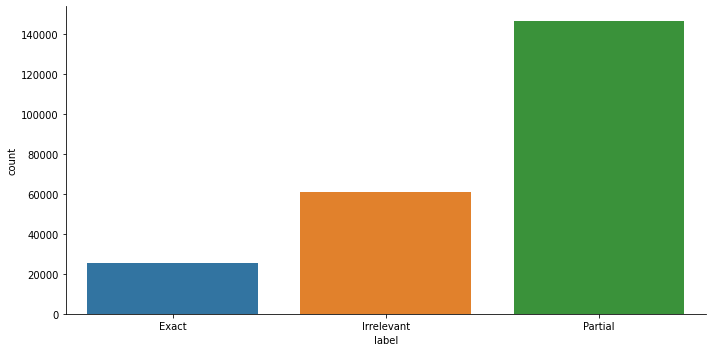

In [ ]:
sns.catplot(x='label', kind='count', data=label_df, height=5, aspect=2)
plt.show()



*   Majority of product had a partial relevance  i.e most of the products are partially relevant.
* We will solve this as a classification problem because that will help us in ranking our products easily. 
* Fewer items had irrelevant lables,Very few products had exact match
* There is a class imbalance present in the data






###EDA Product_uid

max times a product has occured 46
min times a product has occured 1
Total number of unique products 42986



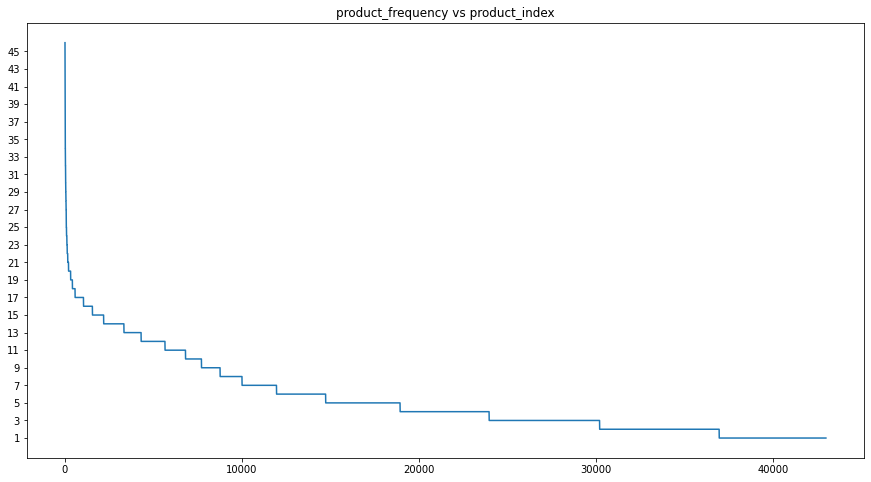

In [ ]:


prod_counts=label_df['product_id'].value_counts()
print('max times a product has occured', max(prod_counts))
print('min times a product has occured', min(prod_counts))
print('Total number of unique products', len(prod_counts))
print('')

plt.figure(figsize=(15,8))
plt.title('product_frequency vs product_index')
plt.plot(prod_counts.values)
plt.yticks(np.arange(min(prod_counts.values), max(prod_counts.values)+1, 2.0))
plt.show()



There are more than 35000 products that occur multiple times i.e we have multiple search queries for the same product and corresponding relevance label for them 

###Merging the product_df, label_df and query_df

In [ ]:
temp_df = pd.merge(label_df, query_df, on='query_id', how='left')
temp_df = temp_df.reset_index(drop=True)
temp_df

,id,query_id,product_id,label,query,query_class
0,0,0,25434,Exact,salon chair,Massage Chairs
1,1,0,12088,Irrelevant,salon chair,Massage Chairs
2,2,0,42931,Exact,salon chair,Massage Chairs
3,3,0,2636,Exact,salon chair,Massage Chairs
4,4,0,42923,Exact,salon chair,Massage Chairs
...,...,...,...,...,...,...
233443,234010,478,15439,Partial,worn leather office chair,Office Chairs
233444,234011,478,451,Partial,worn leather office chair,Office Chairs
233445,234012,478,30764,Irrelevant,worn leather office chair,Office Chairs
233446,234013,478,16796,Partial,worn leather office chair,Office Chairs


In [ ]:
temp_df.isna().sum()

id               0
query_id         0
product_id       0
label            0
query            0
query_class    328
dtype: int64

In [ ]:
combined_df = pd.merge(temp_df, product_df, on='product_id', how='left')
combined_df = combined_df.reset_index(drop=True)
combined_df


,id,query_id,product_id,label,query,query_class,product_name,product_class,category hierarchy,product_description,product_features,rating_count,average_rating,review_count
0,0,0,25434,Exact,salon chair,Massage Chairs,21.7 '' w waiting room chair with wood frame,Waiting Room Chairs,Commercial Business Furniture / Commercial Off...,"this is a salon chair , barber chair for a hai...",backupholsterycolor : champagne|primarymateria...,NaN,NaN,NaN
1,1,0,12088,Irrelevant,salon chair,Massage Chairs,22.5 '' wide polyester side chair,Accent Chairs,Furniture / Living Room Furniture / Chairs & S...,add a beautiful accent to any room with this m...,overalldepth-fronttoback:27.5|design : side ch...,NaN,NaN,NaN
2,2,0,42931,Exact,salon chair,Massage Chairs,24.4 '' w metal lounge chair with metal frame,Reception Seating Chairs,Shop Product Type / Chairs / Guest & Reception...,the heavy duty barber chair is built to last ....,color : black|seatcushionorupholsteryfillmater...,1.0,4.0,0.0
3,3,0,2636,Exact,salon chair,Massage Chairs,25 '' wide faux leather manual swivel standard...,Recliners,Furniture / Living Room Furniture / Chairs & S...,this is a chair designed for your barbershop ....,design : standard recliner|warrantylength:60 d...,5.0,5.0,3.0
4,4,0,42923,Exact,salon chair,Massage Chairs,27.6 '' w antimicrobial leather seat waiting r...,Waiting Room Chairs,Commercial Business Furniture / Commercial Off...,NaN,backupholsterymaterial : leather|armsincluded ...,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
233443,234010,478,15439,Partial,worn leather office chair,Office Chairs,fellsburg linen upholstered parsons chair,Accent Chairs|Dining Chairs,Furniture / Kitchen & Dining Furniture / Dinin...,NaN,numberofchairsincluded:4|legmaterial : solid w...,1729.0,4.0,1193.0
233444,234011,478,451,Partial,worn leather office chair,Office Chairs,olin upholstered side chair,Dining Chairs,Furniture / Kitchen & Dining Furniture / Dinin...,if you are looking for a simple yet sleek dini...,productcare : wipe with damp cloth|legcolor : ...,2880.0,4.5,1921.0
233445,234012,478,30764,Irrelevant,worn leather office chair,Office Chairs,barbay lounge chair cushion,Furniture Cushions,NaN,NaN,durability : mildew resistant|furnituretype : ...,74.0,4.5,51.0
233446,234013,478,16796,Partial,worn leather office chair,Office Chairs,haings upholstered parsons chair,Accent Chairs|Dining Chairs,Furniture / Kitchen & Dining Furniture / Dinin...,this set of 2 armless side chairs boasts an up...,dssecondaryproductstyle : transitional traditi...,50.0,4.5,39.0


In [ ]:
combined_df.shape

(233448, 14)

In [ ]:
from sklearn.model_selection import train_test_split

def split_stratified_into_train_val_test(df_input, stratify_colname,
                                         frac_train=0.75,frac_test=0.25,
                                         random_state=5):
    '''
    Splits a Pandas dataframe into three subsets (train, val, and test)
    following fractional ratios provided by the user, where each subset is
    stratified by the values in a specific column (that is, each subset has
    the same relative frequency of the values in the column). It performs this
    splitting by running train_test_split() twice.

    Parameters
    ----------
    df_input : Pandas dataframe
        Input dataframe to be split.
    stratify_colname : str
        The name of the column that will be used for stratification. Usually
        this column would be for the label.
    frac_train : float
    frac_val   : float
    frac_test  : float
        The ratios with which the dataframe will be split into train, val, and
        test data. The values should be expressed as float fractions and should
        sum to 1.0.
    random_state : int, None, or RandomStateInstance
        Value to be passed to train_test_split().

    Returns
    -------
    df_train, df_val, df_test :
        Dataframes containing the three splits.
    '''

    if frac_train +  frac_test != 1.0:
        raise ValueError('fractions %f, %f do not add up to 1.0' % \
                         (frac_train,  frac_test))

    if stratify_colname not in df_input.columns:
        raise ValueError('%s is not a column in the dataframe' % (stratify_colname))

    X = df_input # Contains all columns.
    y = df_input[[stratify_colname]] # Dataframe of just the column on which to stratify.

    # Split original dataframe into train and temp dataframes.
    df_train, df_test, y_train, y_test = train_test_split(X,
                                                          y,
                                                          stratify=y,
                                                          test_size=(1.0 - frac_train),
                                                          random_state=random_state)

    # Split the temp dataframe into val and test dataframes.
    # relative_frac_test = frac_test / (frac_val + frac_test)
    # df_val, df_test, y_val, y_test = train_test_split(df_temp,
    #                                                   y_temp,
    #                                                   stratify=y_temp,
    #                                                   test_size=relative_frac_test,
    #                                                   random_state=random_state)

    assert len(df_input) == len(df_train) + len(df_test)

    return df_train, df_test
train_df, test_df=split_stratified_into_train_val_test(combined_df, stratify_colname='label')

In [ ]:
train_df= train_df.reset_index(drop=True)
test_df =  test_df.reset_index(drop=True)

In [ ]:
train_df.isna().sum()

id                         0
query_id                   0
product_id                 0
label                      0
query                      0
query_class              226
product_name               0
product_class          13482
category hierarchy      5246
product_description    23110
product_features           0
rating_count           39550
average_rating         39550
review_count           39550
dtype: int64

In [ ]:

test_df.isna().sum()

id                         0
query_id                   0
product_id                 0
label                      0
query                      0
query_class              102
product_name               0
product_class           4481
category hierarchy      1825
product_description     7674
product_features           0
rating_count           13168
average_rating         13168
review_count           13168
dtype: int64

### Cleaning product features
product_features column has | delimited string of attribute:value pairs which describe the product. Attributes seems to be clustered without space between words. As a quick workaround , we can omit attributes and select only value part for further processing.
As a future step we can try including attributes as well after extensive cleaning

In [ ]:
train_df['product_features'] = train_df['product_features'].str.split('|')
test_df['product_features'] = test_df['product_features'].str.split('|')

In [ ]:
train_df['product_features'][100]

['pattern : solid color',
 'upholsterymaterial : velvet',
 'legmaterial : wood',
 'loveseatdepth-fronttoback:28.5',
 'legcolor : natural',
 'backfillmaterialdetails : polyurethane foam',
 'levelofassembly : partial assembly',
 'chairseatheightfloortoseat:18.5',
 'design : standard',
 'loveseatwidth-sidetoside:50',
 'minimumdoorwidth-sidetoside:27.75',
 'woodspecies : birch',
 'chairheight-toptobottom:28',
 'chairseatwidth-sidetoside:20.5',
 'dssecondaryproductstyle : contemporary boho',
 'weightcapacity:250',
 'piecesincludednew : armchair',
 'armtype : recessed arms',
 'chairbackheight-seattotopofback:9.5',
 'framematerial : solid wood',
 'seatingcapacity:4',
 'chairweightcapacity:200',
 'loveseatbackheight-seattotopofback:9.5',
 'chairwidth-sidetoside:27.75',
 'chairdepth-fronttoback:28.5',
 'seatfillmaterial : foam',
 'loveseatseatdepth-fronttoback:20',
 'loveseatseatheight-floortoseat:18.5',
 'loveseatweight:48.6',
 'waterrepellant : no resiliency',
 'piecesincludednew : loveseat',

In [ ]:

def preprocess_pf(x):
  regexp = re.compile(":(.*)$")

  k = [regexp.search(s).group(1).strip() for s in x if regexp.search(s) ]
  cleaned =list(set(k))
  cleaned = ' '.join(map(str, cleaned))
  
  return cleaned
train_df['product_features'] = train_df['product_features'].apply(lambda x:preprocess_pf(x)) 
test_df['product_features'] = test_df['product_features'].apply(lambda x:preprocess_pf(x))

In [ ]:
train_df['product_features'][100]


'30.64 residential use 50 loveseat 9.5 natural birch no resiliency polyurethane foam contemporary boho 200 250 standard 3 1 27.75 28 china 400 wood no 4 43 modern & contemporary 20.5 armchair yes tight back 28.5 recessed arms 20 partial assembly 48.6 18.5 2 velvet solid wood solid color foam'

In [ ]:
test_df['product_features'][100]

'16 300 stainless steel residential use 18 black red faux leather none brown white solid back modern gray china no natural variation no side chair metal modern & contemporary transitional modern yes 18.5 2 sliver no distressing foam'

###Missing value imputation

In [ ]:
train_df['rating_count'] = train_df['rating_count'].fillna(0)
train_df['average_rating'] = train_df['average_rating'].fillna(0)
train_df['review_count'] = train_df['review_count'].fillna(0)
test_df['rating_count'] = test_df['rating_count'].fillna(0)
test_df['average_rating'] = test_df['average_rating'].fillna(0)
test_df['review_count'] = test_df['review_count'].fillna(0)

####Missing value immputation: query class
For query_class we will be filling the missing values from query as we will see both query_class and query are very similar

In [ ]:
null_df_tn = train_df[train_df['query_class'].isnull()]
null_df_ts = test_df[test_df['query_class'].isnull()]

In [ ]:
null_df_tn['query_class'] =null_df_tn['query'].copy()
null_df_ts['query_class'] =null_df_ts['query'].copy()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [ ]:
train_df['query_class'].loc[null_df_tn.index] = null_df_tn['query'].values
test_df['query_class'].loc[null_df_ts.index] = null_df_ts['query'].values

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


In [ ]:
for col in train_df.columns:
  print('{} has {} null values'.format(col, train_df[col].isna().values.sum()))
print("-------------------------")
for col in test_df.columns:
  print('{} has {} null values'.format(col, test_df[col].isna().values.sum()))

id has 0 null values
query_id has 0 null values
product_id has 0 null values
label has 0 null values
query has 0 null values
query_class has 0 null values
product_name has 0 null values
product_class has 13482 null values
category hierarchy has 5246 null values
product_description has 23110 null values
product_features has 0 null values
rating_count has 0 null values
average_rating has 0 null values
review_count has 0 null values
-------------------------
id has 0 null values
query_id has 0 null values
product_id has 0 null values
label has 0 null values
query has 0 null values
query_class has 0 null values
product_name has 0 null values
product_class has 4481 null values
category hierarchy has 1825 null values
product_description has 7674 null values
product_features has 0 null values
rating_count has 0 null values
average_rating has 0 null values
review_count has 0 null values


####Missing value immputation: product_class
For product_class we will be filling the missing values from product_name as we will see both product_class and product_name are very similar

In [ ]:
null_df_tn = train_df[train_df['product_class'].isnull()]
null_df_ts = test_df[test_df['product_class'].isnull()]

In [ ]:
null_df_tn['product_class'] = null_df_tn['product_name'].copy()
null_df_ts['product_class'] = null_df_ts['product_name'].copy()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [ ]:
train_df['product_class'].loc[null_df_tn.index] = null_df_tn['product_name'].values
test_df['product_class'].loc[null_df_ts.index] = null_df_ts['product_name'].values

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


In [ ]:
for col in train_df.columns:
  print('{} has {} null values'.format(col, train_df[col].isna().values.sum()))
print("--------------------------")
for col in test_df.columns:
  print('{} has {} null values'.format(col, test_df[col].isna().values.sum()))

id has 0 null values
query_id has 0 null values
product_id has 0 null values
label has 0 null values
query has 0 null values
query_class has 0 null values
product_name has 0 null values
product_class has 0 null values
category hierarchy has 5246 null values
product_description has 23110 null values
product_features has 0 null values
rating_count has 0 null values
average_rating has 0 null values
review_count has 0 null values
--------------------------
id has 0 null values
query_id has 0 null values
product_id has 0 null values
label has 0 null values
query has 0 null values
query_class has 0 null values
product_name has 0 null values
product_class has 0 null values
category hierarchy has 1825 null values
product_description has 7674 null values
product_features has 0 null values
rating_count has 0 null values
average_rating has 0 null values
review_count has 0 null values


####Missing value immputation: categorical hierarchy
Check if category hierarchy is available for any product that belongs to same class. If yes, we will replace with those values

In [ ]:
unique_products_tn = np.unique(train_df['product_class'].dropna().values)
print('Number of unique product classes in train ', len(unique_products_tn))

unique_products_ts = np.unique(test_df['product_class'].dropna().values)
print('Number of unique product classes in test ', len(unique_products_ts))

Number of unique product classes in train  3585
Number of unique product classes in test  2675


In [ ]:
null_df_tn = train_df[train_df['category hierarchy'].isnull()]
notnull_df_tn = train_df.dropna()


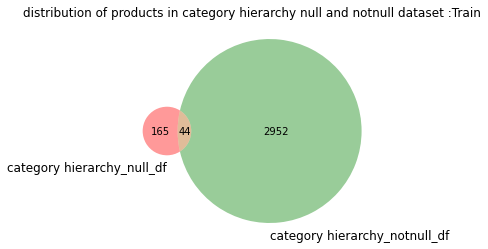

In [ ]:
set1 = set(null_df_tn['product_class'].values)
set2 = set(notnull_df_tn['product_class'].values)

venn2([set1, set2], ('category hierarchy_null_df', 'category hierarchy_notnull_df'))
plt.title('distribution of products in category hierarchy null and notnull dataset :Train')
plt.show()

In [ ]:
null_df_ts = test_df[test_df['category hierarchy'].isnull()]
notnull_df_ts = test_df.dropna()

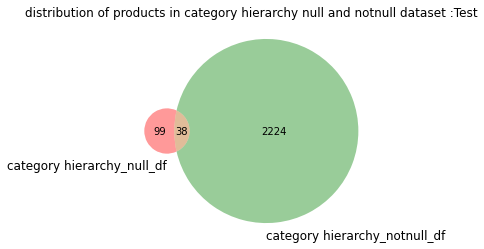

In [ ]:
set1 = set(null_df_ts['product_class'].values)
set2 = set(notnull_df_ts['product_class'].values)

venn2([set1, set2], ('category hierarchy_null_df', 'category hierarchy_notnull_df'))
plt.title('distribution of products in category hierarchy null and notnull dataset :Test')
plt.show()

There are some unique product classes that are present in both data sets where category hierarchy value is null and not null. So, we can use this to replace null values in category hierarchy column

In [ ]:
category_dict_tn = dict(zip(notnull_df_tn['product_class'], notnull_df_tn['category hierarchy']))
category_dict_ts = dict(zip(notnull_df_ts['product_class'], notnull_df_ts['category hierarchy']))

In [ ]:
null_df_tn['category hierarchy']=null_df_tn['product_class'].map(category_dict_tn)
null_df_ts['category hierarchy']=null_df_ts['product_class'].map(category_dict_ts)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [ ]:
train_df['category hierarchy'].loc[null_df_tn.index] = null_df_tn['category hierarchy'].values
test_df['category hierarchy'].loc[null_df_ts.index] = null_df_ts['category hierarchy'].values

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


In [ ]:
for col in train_df.columns:
  print('{} has {} null values'.format(col, train_df[col].isna().values.sum()))
for col in test_df.columns:
  print('{} has {} null values'.format(col, test_df[col].isna().values.sum()))

id has 0 null values
query_id has 0 null values
product_id has 0 null values
label has 0 null values
query has 0 null values
query_class has 0 null values
product_name has 0 null values
product_class has 0 null values
category hierarchy has 533 null values
product_description has 23110 null values
product_features has 0 null values
rating_count has 0 null values
average_rating has 0 null values
review_count has 0 null values
id has 0 null values
query_id has 0 null values
product_id has 0 null values
label has 0 null values
query has 0 null values
query_class has 0 null values
product_name has 0 null values
product_class has 0 null values
category hierarchy has 193 null values
product_description has 7674 null values
product_features has 0 null values
rating_count has 0 null values
average_rating has 0 null values
review_count has 0 null values


Now we can see our category hierarchy null values went down from 5246 to 533.
Remaining null values we will replace with product class itself.

In [ ]:
null_df_tn = train_df[train_df['category hierarchy'].isnull()]
null_df_ts = test_df[test_df['category hierarchy'].isnull()]

In [ ]:
null_df_tn['category hierarchy'] = null_df_tn['product_class'].copy()
null_df_ts['category hierarchy'] = null_df_ts['product_class'].copy()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [ ]:
train_df['category hierarchy'].loc[null_df_tn.index] = null_df_tn['category hierarchy'].values
test_df['category hierarchy'].loc[null_df_ts.index] = null_df_ts['category hierarchy'].values

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


In [ ]:
for col in train_df.columns:
  print('{} has {} null values'.format(col, train_df[col].isna().values.sum()))

id has 0 null values
query_id has 0 null values
product_id has 0 null values
label has 0 null values
query has 0 null values
query_class has 0 null values
product_name has 0 null values
product_class has 0 null values
category hierarchy has 0 null values
product_description has 23110 null values
product_features has 0 null values
rating_count has 0 null values
average_rating has 0 null values
review_count has 0 null values


In [ ]:
for col in test_df.columns:
  print('{} has {} null values'.format(col, test_df[col].isna().values.sum()))

id has 0 null values
query_id has 0 null values
product_id has 0 null values
label has 0 null values
query has 0 null values
query_class has 0 null values
product_name has 0 null values
product_class has 0 null values
category hierarchy has 0 null values
product_description has 7674 null values
product_features has 0 null values
rating_count has 0 null values
average_rating has 0 null values
review_count has 0 null values


####Missing value immputation: product_description
For product_description we will be filling the missing values from product_features as we will see both product_description and product_features are similar

In [ ]:
null_df_tn = train_df[train_df['product_description'].isnull()]
null_df_ts = test_df[test_df['product_description'].isnull()]

In [ ]:
null_df_tn[' product_description'] = null_df_tn['product_features'].copy()
null_df_ts[' product_description'] = null_df_ts['product_features'].copy()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [ ]:
train_df['product_description'].loc[null_df_tn.index] = null_df_tn['product_features'].values
test_df['product_description'].loc[null_df_ts.index] = null_df_ts['product_features'].values

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


In [ ]:
for col in train_df.columns:
  print('{} has {} null values'.format(col, train_df[col].isna().values.sum()))

id has 0 null values
query_id has 0 null values
product_id has 0 null values
label has 0 null values
query has 0 null values
query_class has 0 null values
product_name has 0 null values
product_class has 0 null values
category hierarchy has 0 null values
product_description has 0 null values
product_features has 0 null values
rating_count has 0 null values
average_rating has 0 null values
review_count has 0 null values


In [ ]:
for col in test_df.columns:
  print('{} has {} null values'.format(col, test_df[col].isna().values.sum()))

id has 0 null values
query_id has 0 null values
product_id has 0 null values
label has 0 null values
query has 0 null values
query_class has 0 null values
product_name has 0 null values
product_class has 0 null values
category hierarchy has 0 null values
product_description has 0 null values
product_features has 0 null values
rating_count has 0 null values
average_rating has 0 null values
review_count has 0 null values



####Comparing product_description and product_features

In [ ]:


train_df['product_description'][40] 



'reinvent your bedroom with the modern elegance of the netti bed . this chic bed is upholstered in an elegant linen-like fabric that provides ample comfort for you to lean against as you read or watch tv . biscuit tufting and black feet lend a clean , contemporary look . stylish and practical , the netti is fitted with two drawers at the footboard with space to store clothes , sheets , and more . the netti bed is made in malaysia and requires assembly .'

In [ ]:
train_df['product_features'][40] 

'2.36 residential use other 24.41 138.45 600 30 days 2.76 limited 38.43 modern non residential use rectangular charcoal gray polyester fully upholstered gray full assembly needed 46.26 30.55 panel 100 % polyester no distressing no natural variation 5.31 84.65 platform no rubberwood , mdf 14 drawers transitional modern beige yes linen-like polyester 18.5 solid + manufactured wood 64.38 10 mdf 98.11 malaysia 80.12 80.13'

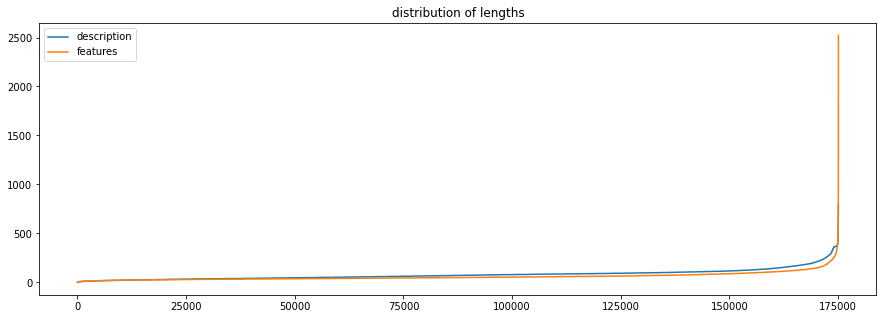

In [ ]:
temp_d= train_df[['product_features','product_description']]
len_desc = temp_d['product_description'].apply(lambda x : len(x.split()))
len_feature = temp_d['product_features'].apply(lambda x : len(x.split()))

plt.figure(figsize=(15,5))
plt.plot(np.sort(len_desc.values),label="description")
plt.plot(np.sort(len_feature.values),label="features")
plt.title('distribution of lengths')
plt.legend()
plt.show()

In [ ]:
train_df.to_csv(path+r'train_df.csv',index=False)
test_df.to_csv(path+r'test_df.csv',index=False)

On close inspection we see that product description and  product features are very similar texts. We will explore them more after data cleaning.

## Cleaning of text data

In [ ]:
train_df.head()


,id,query_id,product_id,label,query,query_class,product_name,product_class,category hierarchy,product_description,product_features,rating_count,average_rating,review_count
0,231568,131,29684,Irrelevant,kids chair,Kids Chairs,garrett rocking chair with cushion,Patio Rockers & Gliders,Outdoor / Outdoor & Patio Furniture / Outdoor ...,relax with this 2 pieces folding rocking chair...,"navy blue , gray powder-coated steel 35.5 resi...",192.0,4.5,152.0
1,200197,476,18616,Exact,hardwood beds,Beds,atalee king standard bed,Beds,Furniture / Bedroom Furniture / Beds & Headboa...,the atalee bed provides a commanding presence ...,residential use other 117 king none 52 200 mod...,0.0,0.0,0.0
2,164626,413,9365,Partial,burruss patio sectional with cushions,Outdoor Conversation Sets,washtenaw patio sofa with cushions,Patio Sofas,Outdoor / Outdoor & Patio Furniture / Outdoor ...,this patio sofa with cushions has room for thr...,resin wicker patio sofa 6.5 traditional 38 850...,0.0,0.0,0.0
3,178669,427,12848,Partial,lowes tile,Floor & Wall Tile,penny 1 '' x 1 '' porcelain mosaic wall & floo...,Floor & Wall Tile,"Home Improvement / Flooring, Walls & Ceiling /...",our penny 1 '' x 1 '' porcelain mosaic wall & ...,impervious heat resistant fire resistant resid...,52.0,5.0,39.0
4,20622,140,16271,Partial,wire basket with dividers,"Boxes, Bins, Baskets, & Buckets",galvanized divided organizer metal/wire crate,"Boxes, Bins, Baskets, & Buckets",Storage & Organization / Storage Containers & ...,the galvanized divided organizer metal/wire cr...,galvanized metal/wire silver rectangle 1 no in...,119.0,5.0,75.0


In [ ]:
test_df.head()

,id,query_id,product_id,label,query,query_class,product_name,product_class,category hierarchy,product_description,product_features,rating_count,average_rating,review_count
0,118557,245,27720,Partial,anchor decor,Wall Décor,shabby architectural window wall decor,Wall Décor,Décor & Pillows / Wall Décor / Wall Accents,"the sanctuary of home , in these times , is wh...",residential use 30 architecture non residentia...,2.0,5.0,2.0
1,57106,435,38339,Partial,shoe closet,Shoe Storage,7 pair shoe storage bench,Benches|Shoe Storage,Storage & Organization / Shoe Storage / All Sh...,looking for a simple and functional shoe bench...,light wood residential use 30 limited shoe sto...,452.0,4.5,300.0
2,214975,33,26413,Partial,non slip shower floor tile,Floor & Wall Tile,argana 8 '' x 8 '' cement patterned wall & flo...,Floor & Wall Tile,"Home Improvement / Flooring, Walls & Ceiling /...",this field tile offers a distinct perspective ...,"cement , natural pigments , and concrete milde...",51.0,4.5,39.0
3,224306,116,35276,Partial,brockham solid blackout thermal grommet curtai...,Curtains & Drapes,christmas decorations old fashioned concept tw...,Curtains & Drapes,Décor & Pillows / Window Treatments / Curtains...,this 2 panels curtain set is printed on 100 % ...,semi-sheer 54 1.5 gray/green/pink indoor / out...,0.0,0.0,0.0
4,67664,26,23900,Partial,leather chairs,Accent Chairs,carlita papasan patio chair,Patio Lounge Chairs,Outdoor / Outdoor & Patio Furniture / Outdoor ...,"this papasan chair is a resort grade , trendy ...",residential use 50 black mid-century modern mi...,89.0,5.0,60.0


In [ ]:


def unit_counts(column):
  words = ' '.join(train_df[column].unique()).split()
  units = ['feet', 'foot','ft.','fathom', 'fm','fm.','inches', 'inchs','in', 'inch','in.', 'centi','cm.' ,'yd.', 'yd','yard', 'yds',
          'ac', 'ac.' , 'acre', 'sq', 'square', 'sq.', 'lb', 'lb.','lbs', 'pound', 'pounds','oz', 'ozs', 'ounce', 'ounces', 'oz.',
          'g', 'gram', 'gr', 'mg', 'st', 'st.', 'stone', 'kg', 'tsp', 'g.', 'tbsp', 'qt', 'ml', 'ml.', 'l',  'l', 'litre','pt', 
          'pt.', 'gal', 'gals', 'gallon', 'gallons','galons', 'gals.','gal.', 'mph', 'cal', 'kn','metre', 'm', 'cm', 'km']
  counts = {}
  for unit in units:
    cnt = list(words).count(unit)
    counts[unit] = cnt
  return counts



In [ ]:
print(unit_counts('product_description'))
print(unit_counts('product_features'))
print(unit_counts('product_name'))
print(unit_counts('query'))
print(unit_counts('query_class'))

{'feet': 1366, 'foot': 476, 'ft.': 284, 'fathom': 0, 'fm': 0, 'fm.': 0, 'inches': 754, 'inchs': 4, 'in': 34407, 'inch': 245, 'in.': 6, 'centi': 0, 'cm.': 0, 'yd.': 0, 'yd': 0, 'yard': 225, 'yds': 0, 'ac': 50, 'ac.': 0, 'acre': 0, 'sq': 24, 'square': 1726, 'sq.': 0, 'lb': 106, 'lb.': 0, 'lbs': 786, 'pound': 32, 'pounds': 192, 'oz': 53, 'ozs': 0, 'ounce': 4, 'ounces': 15, 'oz.': 0, 'g': 4, 'gram': 0, 'gr': 0, 'mg': 0, 'st': 0, 'st.': 5, 'stone': 750, 'kg': 55, 'tsp': 2, 'g.': 1, 'tbsp': 1, 'qt': 51, 'ml': 3, 'ml.': 0, 'l': 355, 'litre': 0, 'pt': 0, 'pt.': 0, 'gal': 13, 'gals': 2, 'gallon': 40, 'gallons': 46, 'galons': 0, 'gals.': 0, 'gal.': 0, 'mph': 2, 'cal': 11, 'kn': 0, 'metre': 0, 'm': 14, 'cm': 184, 'km': 0}
{'feet': 135, 'foot': 66, 'ft.': 1200, 'fathom': 0, 'fm': 0, 'fm.': 0, 'inches': 911, 'inchs': 0, 'in': 13032, 'inch': 41, 'in.': 34, 'centi': 0, 'cm.': 0, 'yd.': 0, 'yd': 0, 'yard': 4, 'yds': 0, 'ac': 29, 'ac.': 0, 'acre': 0, 'sq': 3, 'square': 4138, 'sq.': 0, 'lb': 11, 'lb.': 





*  In lots of product_name, dimensions of products are mentioned. A very common way of representing them is like '8 ft. x 5 ft. x 8 ft.' with whitespaces in between. The same is observed in product_description and features.
    In product_name units are mostly represented as (in. ft. square lbs. oz. gallon. l) but in product_description and query units are represented in multiple ways for example inch as (in. in inch) hence these need to be standardized.

*       Also, in query, there were some common errors when specifying measurements. Some examples are '7qt', '54 in', '36"'Hence we need to seperate numbers from letters.


### cleaning



1.   Seperate numbers from words: "9x12" -> "9 x 12" , "5gal" -> "5 gal" ...

2.   Bring all units of measurements to a consistent representation.






In [ ]:

#We are not including units (ft. lb. sq. ...) as the full stop will be taken care by 
#the re.split(r'\W+', sent) function in the preprocessing function

#In description and name, 'inch' is generally found as 'in.' where as in query,
#its found both as 'in' and 'in.' thus we deal with both cases seperately. Thus a seperate 
#preprocessing function for search terms

#we are not using stemming and stopwords now. We will be stemming after correction of query

#'in.','in' to inch is taken care of in preprocessing step
#'inches' to inch will be taken care in stemming. 

stop_words = set(stopwords.words('english'))
def standardize_units(text):
  text = " " + text + " "
  text = re.sub('( gal | gals | galon )',' gallon ',text)
  text = re.sub('( ft | fts | feets | foot | foots )',' feet ',text)
  text = re.sub('( squares | sq )',' square ',text)
  text = re.sub('( lb | lbs | pounds )',' pound ',text)
  text = re.sub('( oz | ozs | ounces | ounc )',' ounce ',text)
  text = re.sub('( wide | width | w )',' width ',text)
  return text

def preprocessing(sent):
  sent = sent.replace('in.', ' inch ')#If we dont to this then 'in.' will be turned to 'in' in the next step
  sent =  re.sub(r'(\d+) \'\'', r'\1 inch', sent) #some times inch is represented in symbol
  words = re.split(r'\W+', sent)
  words = [word.lower() for word in words]
  res = re.sub("[A-Za-z]+", lambda ele: " " + ele[0] + " ", ' '.join(words)) #add space between number and alphabets in a string
  cleaned = standardize_units(res) 
  cleaned = ' '.join(cleaned.split()) #removing extra whitespaces
  words = cleaned.split()
  words = [w for w in words if not w in stop_words]

  return ' '.join(words)

def preprocessing_search(sent):
  sent = sent.replace('in.', ' inch ')
  sent =  re.sub(r'(\d+) \'\'', r'\1 inch', sent) #some times inch is represented in symbol
  words = re.split(r'\W+', sent)
  words = [word.lower() for word in words]
  res = re.sub("[A-Za-z]+", lambda ele: " " + ele[0] + " ", ' '.join(words)) #add space between number and alphabets in a string
  res = standardize_units(res) 
  res = res.replace(' in ', ' inch ') #in search_terms 'in' is used more for 'inch' than as a preposition hence this step shouldn't hurt
  cleaned = ' '.join(res.split()) #removing extra whitespaces
  words = cleaned.split()
  words = [w for w in words if not w in stop_words]

  return ' '.join(words)

In [ ]:

train_df['cleaned_name'] = train_df['product_name'].apply(lambda x : preprocessing(x))
train_df['cleaned_class'] = train_df['product_class'].apply(lambda x : preprocessing(x))
train_df['cleaned_description'] = train_df['product_description'].apply(lambda x : preprocessing(x))
train_df['cleaned_features'] = train_df['product_features'].apply(lambda x : preprocessing(x))
train_df['cleaned_hierarchy'] = train_df['category hierarchy'].apply(lambda x : preprocessing(x))

#preprocessing for search is implemented in a slight different manner 
train_df['cleaned_query'] = train_df['query'].apply(lambda x : preprocessing_search(x))
train_df['cleaned_query_class'] = train_df['query_class'].apply(lambda x : preprocessing_search(x))
train_df.head()


,id,query_id,product_id,label,query,query_class,product_name,product_class,category hierarchy,product_description,...,rating_count,average_rating,review_count,cleaned_name,cleaned_class,cleaned_description,cleaned_features,cleaned_hierarchy,cleaned_query,cleaned_query_class
0,231568,131,29684,Irrelevant,kids chair,Kids Chairs,garrett rocking chair with cushion,Patio Rockers & Gliders,Outdoor / Outdoor & Patio Furniture / Outdoor ...,relax with this 2 pieces folding rocking chair...,...,192.0,4.5,152.0,garrett rocking chair cushion,patio rockers gliders,relax 2 pieces folding rocking chair set two r...,navy blue gray powder coated steel 35 5 reside...,outdoor outdoor patio furniture outdoor seatin...,kids chair,kids chairs
1,200197,476,18616,Exact,hardwood beds,Beds,atalee king standard bed,Beds,Furniture / Bedroom Furniture / Beds & Headboa...,the atalee bed provides a commanding presence ...,...,0.0,0.0,0.0,atalee king standard bed,beds,atalee bed provides commanding presence room c...,residential use 117 king none 52 200 modern 80...,furniture bedroom furniture beds headboards beds,hardwood beds,beds
2,164626,413,9365,Partial,burruss patio sectional with cushions,Outdoor Conversation Sets,washtenaw patio sofa with cushions,Patio Sofas,Outdoor / Outdoor & Patio Furniture / Outdoor ...,this patio sofa with cushions has room for thr...,...,0.0,0.0,0.0,washtenaw patio sofa cushions,patio sofas,patio sofa cushions room three sit comfortably...,resin wicker patio sofa 6 5 traditional 38 850...,outdoor outdoor patio furniture outdoor seatin...,burruss patio sectional cushions,outdoor conversation sets
3,178669,427,12848,Partial,lowes tile,Floor & Wall Tile,penny 1 '' x 1 '' porcelain mosaic wall & floo...,Floor & Wall Tile,"Home Improvement / Flooring, Walls & Ceiling /...",our penny 1 '' x 1 '' porcelain mosaic wall & ...,...,52.0,5.0,39.0,penny 1 inch x 1 inch porcelain mosaic wall fl...,floor wall tile,penny 1 inch x 1 inch porcelain mosaic wall fl...,impervious heat resistant fire resistant resid...,home improvement flooring walls ceiling floor ...,lowes tile,floor wall tile
4,20622,140,16271,Partial,wire basket with dividers,"Boxes, Bins, Baskets, & Buckets",galvanized divided organizer metal/wire crate,"Boxes, Bins, Baskets, & Buckets",Storage & Organization / Storage Containers & ...,the galvanized divided organizer metal/wire cr...,...,119.0,5.0,75.0,galvanized divided organizer metal wire crate,boxes bins baskets buckets,galvanized divided organizer metal wire crate ...,galvanized metal wire silver rectangle 1 indus...,storage organization storage containers drawer...,wire basket dividers,boxes bins baskets buckets


In [ ]:
train_df.columns

Index(['id', 'query_id', 'product_id', 'label', 'query', 'query_class',
       'product_name', 'product_class', 'category hierarchy',
       'product_description', 'product_features', 'rating_count',
       'average_rating', 'review_count', 'cleaned_name', 'cleaned_class',
       'cleaned_description', 'cleaned_features', 'cleaned_hierarchy',
       'cleaned_query', 'cleaned_query_class'],
      dtype='object')

In [ ]:

test_df['cleaned_name'] = test_df['product_name'].apply(lambda x : preprocessing(x))
test_df['cleaned_class'] = test_df['product_class'].apply(lambda x : preprocessing(x))
test_df['cleaned_description'] = test_df['product_description'].apply(lambda x : preprocessing(x))
test_df['cleaned_features'] = test_df['product_features'].apply(lambda x : preprocessing(x))
test_df['cleaned_hierarchy'] = test_df['category hierarchy'].apply(lambda x : preprocessing(x))

#preprocessing for search is implemented in a slight different manner 
test_df['cleaned_query'] = test_df['query'].apply(lambda x : preprocessing_search(x))
test_df['cleaned_query_class'] = test_df['query_class'].apply(lambda x : preprocessing_search(x))
test_df.head()


,id,query_id,product_id,label,query,query_class,product_name,product_class,category hierarchy,product_description,...,rating_count,average_rating,review_count,cleaned_name,cleaned_class,cleaned_description,cleaned_features,cleaned_hierarchy,cleaned_query,cleaned_query_class
0,118557,245,27720,Partial,anchor decor,Wall Décor,shabby architectural window wall decor,Wall Décor,Décor & Pillows / Wall Décor / Wall Accents,"the sanctuary of home , in these times , is wh...",...,2.0,5.0,2.0,shabby architectural window wall decor,wall é cor,sanctuary home times go recharge relax many ar...,residential use 30 architecture non residentia...,é cor pillows wall é cor wall accents,anchor decor,wall é cor
1,57106,435,38339,Partial,shoe closet,Shoe Storage,7 pair shoe storage bench,Benches|Shoe Storage,Storage & Organization / Shoe Storage / All Sh...,looking for a simple and functional shoe bench...,...,452.0,4.5,300.0,7 pair shoe storage bench,benches shoe storage,looking simple functional shoe bench shoe rack...,light wood residential use 30 limited shoe sto...,storage organization shoe storage shoe storage,shoe closet,shoe storage
2,214975,33,26413,Partial,non slip shower floor tile,Floor & Wall Tile,argana 8 '' x 8 '' cement patterned wall & flo...,Floor & Wall Tile,"Home Improvement / Flooring, Walls & Ceiling /...",this field tile offers a distinct perspective ...,...,51.0,4.5,39.0,argana 8 inch x 8 inch cement patterned wall f...,floor wall tile,field tile offers distinct perspective morocca...,cement natural pigments concrete mildew resist...,home improvement flooring walls ceiling floor ...,non slip shower floor tile,floor wall tile
3,224306,116,35276,Partial,brockham solid blackout thermal grommet curtai...,Curtains & Drapes,christmas decorations old fashioned concept tw...,Curtains & Drapes,Décor & Pillows / Window Treatments / Curtains...,this 2 panels curtain set is printed on 100 % ...,...,0.0,0.0,0.0,christmas decorations old fashioned concept tw...,curtains drapes,2 panels curtain set printed 100 woven polyest...,semi sheer 54 1 5 gray green pink indoor outdo...,é cor pillows window treatments curtains drape...,brockham solid blackout thermal grommet curtai...,curtains drapes
4,67664,26,23900,Partial,leather chairs,Accent Chairs,carlita papasan patio chair,Patio Lounge Chairs,Outdoor / Outdoor & Patio Furniture / Outdoor ...,"this papasan chair is a resort grade , trendy ...",...,89.0,5.0,60.0,carlita papasan patio chair,patio lounge chairs,papasan chair resort grade trendy comfortable ...,residential use 50 black mid century modern mi...,outdoor outdoor patio furniture outdoor seatin...,leather chairs,accent chairs


###Further cleaning

In [ ]:


#stop word removal and stemming
#We didn't do this before because we wanted to fix the typos in the searh term first 
porter = PorterStemmer()

def stemming(sent):
  words = sent.split()
  words = [porter.stem(word) for word in words]
  return ' '.join(words)

#storing the final data in a new dataframe 'cleaned_df' 
clean_df_train = train_df[['id', 'query_id', 'product_id', 'rating_count', 'average_rating', 'review_count', 'label']]
clean_df_train['name'] = train_df['cleaned_name'].apply(lambda x : stemming(x))
clean_df_train['class'] = train_df['cleaned_class'].apply(lambda x : stemming(x))
clean_df_train['description'] = train_df['cleaned_description'].apply(lambda x : stemming(x))
clean_df_train['features'] = train_df['cleaned_features'].apply(lambda x : stemming(x))
clean_df_train['hierarchy'] = train_df['cleaned_hierarchy'].apply(lambda x : stemming(x))

#stemming for search is implemented in a slight different manner 
clean_df_train['query'] = train_df['cleaned_query'].apply(lambda x : stemming(x))
clean_df_train['query_class'] = train_df['cleaned_query_class'].apply(lambda x : stemming(x))
clean_df_train.head()


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation

,id,query_id,product_id,rating_count,average_rating,review_count,label,name,class,description,features,hierarchy,query,query_class
0,231568,131,29684,192.0,4.5,152.0,Irrelevant,garrett rock chair cushion,patio rocker glider,relax 2 piec fold rock chair set two rock chai...,navi blue gray powder coat steel 35 5 resident...,outdoor outdoor patio furnitur outdoor seat pa...,kid chair,kid chair
1,200197,476,18616,0.0,0.0,0.0,Exact,atale king standard bed,bed,atale bed provid command presenc room contempo...,residenti use 117 king none 52 200 modern 80 s...,furnitur bedroom furnitur bed headboard bed,hardwood bed,bed
2,164626,413,9365,0.0,0.0,0.0,Partial,washtenaw patio sofa cushion,patio sofa,patio sofa cushion room three sit comfort even...,resin wicker patio sofa 6 5 tradit 38 850 79 s...,outdoor outdoor patio furnitur outdoor seat pa...,burruss patio section cushion,outdoor convers set
3,178669,427,12848,52.0,5.0,39.0,Partial,penni 1 inch x 1 inch porcelain mosaic wall fl...,floor wall tile,penni 1 inch x 1 inch porcelain mosaic wall fl...,impervi heat resist fire resist residenti use ...,home improv floor wall ceil floor tile wall ti...,low tile,floor wall tile
4,20622,140,16271,119.0,5.0,75.0,Partial,galvan divid organ metal wire crate,box bin basket bucket,galvan divid organ metal wire crate galvan met...,galvan metal wire silver rectangl 1 industri c...,storag organ storag contain drawer storag contain,wire basket divid,box bin basket bucket


In [ ]:
clean_df_test = test_df[['id', 'query_id', 'product_id', 'rating_count', 'average_rating', 'review_count', 'label']]
clean_df_test['name'] = test_df['cleaned_name'].apply(lambda x : stemming(x))
clean_df_test['class'] = test_df['cleaned_class'].apply(lambda x : stemming(x))
clean_df_test['description'] = test_df['cleaned_description'].apply(lambda x : stemming(x))
clean_df_test['features'] = test_df['cleaned_features'].apply(lambda x : stemming(x))
clean_df_test['hierarchy'] = test_df['cleaned_hierarchy'].apply(lambda x : stemming(x))

#stemming for search is implemented in a slight different manner 
clean_df_test['query'] = test_df['cleaned_query'].apply(lambda x : stemming(x))
clean_df_test['query_class'] = test_df['cleaned_query_class'].apply(lambda x : stemming(x))
clean_df_test.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

,id,query_id,product_id,rating_count,average_rating,review_count,label,name,class,description,features,hierarchy,query,query_class
0,118557,245,27720,2.0,5.0,2.0,Partial,shabbi architectur window wall decor,wall é cor,sanctuari home time go recharg relax mani arch...,residenti use 30 architectur non residenti use...,é cor pillow wall é cor wall accent,anchor decor,wall é cor
1,57106,435,38339,452.0,4.5,300.0,Partial,7 pair shoe storag bench,bench shoe storag,look simpl function shoe bench shoe rack bench...,light wood residenti use 30 limit shoe storag ...,storag organ shoe storag shoe storag,shoe closet,shoe storag
2,214975,33,26413,51.0,4.5,39.0,Partial,argana 8 inch x 8 inch cement pattern wall flo...,floor wall tile,field tile offer distinct perspect moroccan ol...,cement natur pigment concret mildew resist 5 h...,home improv floor wall ceil floor tile wall tile,non slip shower floor tile,floor wall tile
3,224306,116,35276,0.0,0.0,0.0,Partial,christma decor old fashion concept twig rustic...,curtain drape,2 panel curtain set print 100 woven polyest co...,semi sheer 54 1 5 gray green pink indoor outdo...,é cor pillow window treatment curtain drape 90...,brockham solid blackout thermal grommet curtai...,curtain drape
4,67664,26,23900,89.0,5.0,60.0,Partial,carlita papasan patio chair,patio loung chair,papasan chair resort grade trendi comfort styl...,residenti use 50 black mid centuri modern mild...,outdoor outdoor patio furnitur outdoor seat pa...,leather chair,accent chair


In [ ]:
map_dict = {'Exact':3,'Partial':2,'Irrelevant':1}
clean_df_train['target'] = clean_df_train['label'].map(map_dict)
clean_df_test['target'] = clean_df_test['label'].map(map_dict)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [ ]:
clean_df_train['target'].value_counts()
clean_df_test['target'].value_counts()


2    36658
1    15300
3     6404
Name: target, dtype: int64

In [ ]:
clean_df_train.to_excel(path+r'clean_df_train.xlsx',index=False)
clean_df_test.to_excel(path+r'clean_df_test.xlsx',index=False)

In [5]:
clean_df_train = pd.read_excel(path+r'clean_df_train.xlsx')
clean_df_test= pd.read_excel(path+r'clean_df_test.xlsx')


### Feature Engineering

In [7]:


import math
import re
import xgboost as xgb
from xgboost import XGBClassifier
from nltk import sent_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from gensim.models import Word2Vec
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from numpy.linalg import norm
import pickle
from tqdm.notebook import tqdm
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn import tree
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Features set 1


*   Common words and their count between query,query class and document fields (name, description, features)

*   Cosine coefficient, jacquard coefficient between query and document fields
*   Whether the last word in query is in text fields

*   Length of the query

*   Lengths of document fields 





Creating the Features

In [8]:


# data1_tn = pd.read_excel(path+r'clean_df_train.xlsx')
# data1_ts = pd.read_excel(path+r'clean_df_test.xlsx')
clean_df_train = clean_df_train.dropna().reset_index(drop=True)
clean_df_test = clean_df_test.dropna().reset_index(drop=True)



In [9]:
data1_tn  = clean_df_train
data1_ts = clean_df_test

In [10]:
data1_tn.isnull().sum()

id                0
query_id          0
product_id        0
rating_count      0
average_rating    0
review_count      0
label             0
name              0
class             0
description       0
features          0
hierarchy         0
query             0
query_class       0
target            0
dtype: int64

In [11]:
data1_ts.isnull().sum()

id                0
query_id          0
product_id        0
rating_count      0
average_rating    0
review_count      0
label             0
name              0
class             0
description       0
features          0
hierarchy         0
query             0
query_class       0
target            0
dtype: int64

Common words

In [12]:
def common_words(df, col1, col2):
  """
  Returns common words between each row of col1 and col2 of df in the form of a list. 
  Length of list is number of rows in dataframe
  """
  common_list = []
  for i, row in df[[col1,col2]].iterrows():
    set1 = set(row[col1].split())
    set2 = set(row[col2].split())
    common = set1 & set2
    common = ' '.join(common)
    common_list.append(common)
  return common_list

In [13]:
data1_tn['common_SN'] = common_words(data1_tn,'query', 'name')
data1_tn['common_SD'] = common_words(data1_tn,'query', 'description')
data1_tn['common_SF'] = common_words(data1_tn,'query', 'features')
data1_tn['common_SH'] = common_words(data1_tn,'query', 'hierarchy')
data1_tn['common_SC'] = common_words(data1_tn,'query', 'class')

data1_tn['common_QC_SN'] = common_words(data1_tn,'query_class', 'name')
data1_tn['common_QC_SD'] = common_words(data1_tn,'query_class', 'description')
data1_tn['common_QC_SF'] = common_words(data1_tn,'query_class', 'features')
data1_tn['common_QC_SH'] = common_words(data1_tn,'query_class', 'hierarchy')
data1_tn['common_QC_SC'] = common_words(data1_tn,'query_class', 'class')


data1_tn['num_common_SN'] = data1_tn['common_SN'].apply(lambda x : len(x.split()))
data1_tn['num_common_SD'] = data1_tn['common_SD'].apply(lambda x : len(x.split()))
data1_tn['num_common_SF'] = data1_tn['common_SF'].apply(lambda x : len(x.split()))
data1_tn['num_common_SH'] = data1_tn['common_SH'].apply(lambda x : len(x.split()))
data1_tn['num_common_SC'] = data1_tn['common_SC'].apply(lambda x : len(x.split()))

data1_tn['num_common_QC_SN'] = data1_tn['common_SN'].apply(lambda x : len(x.split()))
data1_tn['num_common_QC_SD'] = data1_tn['common_SD'].apply(lambda x : len(x.split()))
data1_tn['num_common_QC_SF'] = data1_tn['common_SF'].apply(lambda x : len(x.split()))
data1_tn['num_common_QC_SH'] = data1_tn['common_SH'].apply(lambda x : len(x.split()))
data1_tn['num_common_QC_SC'] = data1_tn['common_SC'].apply(lambda x : len(x.split()))


In [14]:
data1_ts['common_SN'] = common_words(data1_ts,'query', 'name')
data1_ts['common_SD'] = common_words(data1_ts,'query', 'description')
data1_ts['common_SF'] = common_words(data1_ts,'query', 'features')
data1_ts['common_SH'] = common_words(data1_ts,'query', 'hierarchy')
data1_ts['common_SC'] = common_words(data1_ts,'query', 'class')

data1_ts['common_QC_SN'] = common_words(data1_ts,'query_class', 'name')
data1_ts['common_QC_SD'] = common_words(data1_ts,'query_class', 'description')
data1_ts['common_QC_SF'] = common_words(data1_ts,'query_class', 'features')
data1_ts['common_QC_SH'] = common_words(data1_ts,'query_class', 'hierarchy')
data1_ts['common_QC_SC'] = common_words(data1_ts,'query_class', 'class')


data1_ts['num_common_SN'] = data1_ts['common_SN'].apply(lambda x : len(x.split()))
data1_ts['num_common_SD'] = data1_ts['common_SD'].apply(lambda x : len(x.split()))
data1_ts['num_common_SF'] = data1_ts['common_SF'].apply(lambda x : len(x.split()))
data1_ts['num_common_SH'] = data1_ts['common_SH'].apply(lambda x : len(x.split()))
data1_ts['num_common_SC'] = data1_ts['common_SC'].apply(lambda x : len(x.split()))

data1_ts['num_common_QC_SN'] = data1_ts['common_SN'].apply(lambda x : len(x.split()))
data1_ts['num_common_QC_SD'] = data1_ts['common_SD'].apply(lambda x : len(x.split()))
data1_ts['num_common_QC_SF'] = data1_ts['common_SF'].apply(lambda x : len(x.split()))
data1_ts['num_common_QC_SH'] = data1_ts['common_SH'].apply(lambda x : len(x.split()))
data1_ts['num_common_QC_SC'] = data1_ts['common_SC'].apply(lambda x : len(x.split()))

In [15]:
def cosine_similarity_sent(sent1, sent2):
  """
  Cosine Similarity between 2 sentences treating them as sets of words
  """

  set1 = set(sent1.split())
  set2 = set(sent2.split())
  numerator = len(set1 & set2)
  denominator = math.sqrt(len(set1)) * math.sqrt(len(set2))
  
  if not denominator:
      return 0.0
  else:
      return numerator / denominator

def jacquard_coefficient_sent(sent1, sent2):
  """
  Jacquard Coefficient between 2 sentences treating them as sets of words
  """

  set1 = set(sent1.split())
  set2 = set(sent2.split())
  numerator = len(set1 & set2)
  denominator = len(set1 | set2)

  if not denominator:
      return 0.0
  else:
      return numerator / denominator

More similarity checks

In [16]:

#COSINE COEFFICIENT
data1_tn['cosine_SN'] = data1_tn.apply(lambda row: cosine_similarity_sent(row['query'], row['name']), axis=1) 
data1_tn['cosine_SD'] = data1_tn.apply(lambda row: cosine_similarity_sent(row['query'], row['description']), axis=1)
data1_tn['cosine_SF'] = data1_tn.apply(lambda row: cosine_similarity_sent(row['query'], row['features']), axis=1)
data1_tn['cosine_SH'] = data1_tn.apply(lambda row: cosine_similarity_sent(row['query'], row['hierarchy']), axis=1) 
data1_tn['cosine_SC'] = data1_tn.apply(lambda row: cosine_similarity_sent(row['query'], row['class']), axis=1)

#JACQUARD COEFFICIENT
data1_tn['jacquard_SN'] = data1_tn.apply(lambda row: jacquard_coefficient_sent(row['query'], row['name']), axis=1) 
data1_tn['jacquard_SD'] = data1_tn.apply(lambda row: jacquard_coefficient_sent(row['query'], row['description']), axis=1)
data1_tn['jacquard_SF'] = data1_tn.apply(lambda row: jacquard_coefficient_sent(row['query'], row['features']), axis=1)
data1_tn['jacquard_SH'] = data1_tn.apply(lambda row: jacquard_coefficient_sent(row['query'], row['hierarchy']), axis=1) 
data1_tn['jacquard_SC'] = data1_tn.apply(lambda row: jacquard_coefficient_sent(row['query'], row['class']), axis=1)
#COSINE COEFFICIENT for query class
data1_tn['cosine_QC_SN'] = data1_tn.apply(lambda row: cosine_similarity_sent(row["query_class"], row['name']), axis=1) 
data1_tn['cosine_QC_SD'] = data1_tn.apply(lambda row: cosine_similarity_sent(row["query_class"], row['description']), axis=1)
data1_tn['cosine_QC_SF'] = data1_tn.apply(lambda row: cosine_similarity_sent(row["query_class"], row['features']), axis=1)
data1_tn['cosine_QC_SH'] = data1_tn.apply(lambda row: cosine_similarity_sent(row["query_class"], row['hierarchy']), axis=1) 
data1_tn['cosine_QC_SC'] = data1_tn.apply(lambda row: cosine_similarity_sent(row["query_class"], row['class']), axis=1)


#JACQUARD COEFFICIENT for query class
data1_tn['jacquard_QC_SN'] = data1_tn.apply(lambda row: jacquard_coefficient_sent(row["query_class"], row['name']), axis=1) 
data1_tn['jacquard_QC_SD'] = data1_tn.apply(lambda row: jacquard_coefficient_sent(row["query_class"], row['description']), axis=1)
data1_tn['jacquard_QC_SF'] = data1_tn.apply(lambda row: jacquard_coefficient_sent(row["query_class"], row['features']), axis=1)
data1_tn['jacquard_QC_SH'] = data1_tn.apply(lambda row: jacquard_coefficient_sent(row["query_class"], row['hierarchy']), axis=1) 
data1_tn['jacquard_QC_SC'] = data1_tn.apply(lambda row: jacquard_coefficient_sent(row["query_class"], row['class']), axis=1)



In [17]:
#COSINE COEFFICIENT
data1_ts['cosine_SN'] = data1_ts.apply(lambda row: cosine_similarity_sent(row['query'], row['name']), axis=1) 
data1_ts['cosine_SD'] = data1_ts.apply(lambda row: cosine_similarity_sent(row['query'], row['description']), axis=1)
data1_ts['cosine_SF'] = data1_ts.apply(lambda row: cosine_similarity_sent(row['query'], row['features']), axis=1)
data1_ts['cosine_SH'] = data1_ts.apply(lambda row: cosine_similarity_sent(row['query'], row['hierarchy']), axis=1) 
data1_ts['cosine_SC'] = data1_ts.apply(lambda row: cosine_similarity_sent(row['query'], row['class']), axis=1)

#JACQUARD COEFFICIENT
data1_ts['jacquard_SN'] = data1_ts.apply(lambda row: jacquard_coefficient_sent(row['query'], row['name']), axis=1) 
data1_ts['jacquard_SD'] = data1_ts.apply(lambda row: jacquard_coefficient_sent(row['query'], row['description']), axis=1)
data1_ts['jacquard_SF'] = data1_ts.apply(lambda row: jacquard_coefficient_sent(row['query'], row['features']), axis=1)
data1_ts['jacquard_SH'] = data1_ts.apply(lambda row: jacquard_coefficient_sent(row['query'], row['hierarchy']), axis=1) 
data1_ts['jacquard_SC'] = data1_ts.apply(lambda row: jacquard_coefficient_sent(row['query'], row['class']), axis=1)
#COSINE COEFFICIENT for query class
data1_ts['cosine_QC_SN'] = data1_ts.apply(lambda row: cosine_similarity_sent(row["query_class"], row['name']), axis=1) 
data1_ts['cosine_QC_SD'] = data1_ts.apply(lambda row: cosine_similarity_sent(row["query_class"], row['description']), axis=1)
data1_ts['cosine_QC_SF'] = data1_ts.apply(lambda row: cosine_similarity_sent(row["query_class"], row['features']), axis=1)
data1_ts['cosine_QC_SH'] = data1_ts.apply(lambda row: cosine_similarity_sent(row["query_class"], row['hierarchy']), axis=1) 
data1_ts['cosine_QC_SC'] = data1_ts.apply(lambda row: cosine_similarity_sent(row["query_class"], row['class']), axis=1)


#JACQUARD COEFFICIENT for query class
data1_ts['jacquard_QC_SN'] = data1_ts.apply(lambda row: jacquard_coefficient_sent(row["query_class"], row['name']), axis=1) 
data1_ts['jacquard_QC_SD'] = data1_ts.apply(lambda row: jacquard_coefficient_sent(row["query_class"], row['description']), axis=1)
data1_ts['jacquard_QC_SF'] = data1_ts.apply(lambda row: jacquard_coefficient_sent(row["query_class"], row['features']), axis=1)
data1_ts['jacquard_QC_SH'] = data1_ts.apply(lambda row: jacquard_coefficient_sent(row["query_class"], row['hierarchy']), axis=1) 
data1_ts['jacquard_QC_SC'] = data1_ts.apply(lambda row: jacquard_coefficient_sent(row["query_class"], row['class']), axis=1)

Length of document fields

In [18]:
data1_tn['len_description'] = data1_tn['description'].apply(lambda x : len(x.split()))
data1_tn['len_features'] = data1_tn['features'].apply(lambda x : len(x.split()))
data1_tn['len_name'] = data1_tn['name'].apply(lambda x : len(x.split()))
data1_tn['len_class'] = data1_tn['class'].apply(lambda x : len(x.split()))
data1_tn['len_hierarchy'] = data1_tn['hierarchy'].apply(lambda x : len(x.split()))

data1_tn['len_query'] = data1_tn['query'].apply(lambda x : len(x.split()))
data1_tn['len_query_class'] = data1_tn['query_class'].apply(lambda x : len(x.split()))

In [19]:
data1_ts['len_description'] = data1_ts['description'].apply(lambda x : len(x.split()))
data1_ts['len_features'] = data1_ts['features'].apply(lambda x : len(x.split()))
data1_ts['len_name'] = data1_ts['name'].apply(lambda x : len(x.split()))
data1_ts['len_class'] = data1_ts['class'].apply(lambda x : len(x.split()))
data1_ts['len_hierarchy'] = data1_ts['hierarchy'].apply(lambda x : len(x.split()))

data1_ts['len_query'] = data1_ts['query'].apply(lambda x : len(x.split()))
data1_ts['len_query_class'] = data1_ts['query_class'].apply(lambda x : len(x.split()))

Presenece of last word from query in document field

In [20]:
#last term

data1_tn['islast_SN'] = data1_tn.apply(lambda row: row['query'].split()[-1] in row['name'].split(), axis=1)
data1_tn['islast_SD'] = data1_tn.apply(lambda row: row['query'].split()[-1] in row['description'].split(), axis=1)
data1_tn['islast_SF'] = data1_tn.apply(lambda row: row['query'].split()[-1] in row['features'].split(), axis=1)
data1_tn['islast_SH'] = data1_tn.apply(lambda row: row['query'].split()[-1] in row['hierarchy'].split(), axis=1)
data1_tn['islast_SC'] = data1_tn.apply(lambda row: row['query'].split()[-1] in row['class'].split(), axis=1)



In [21]:
data1_ts['islast_SN'] = data1_ts.apply(lambda row: row['query'].split()[-1] in row['name'].split(), axis=1)
data1_ts['islast_SD'] = data1_ts.apply(lambda row: row['query'].split()[-1] in row['description'].split(), axis=1)
data1_ts['islast_SF'] = data1_ts.apply(lambda row: row['query'].split()[-1] in row['features'].split(), axis=1)
data1_ts['islast_SH'] = data1_ts.apply(lambda row: row['query'].split()[-1] in row['hierarchy'].split(), axis=1)
data1_ts['islast_SC'] = data1_ts.apply(lambda row: row['query'].split()[-1] in row['class'].split(), axis=1)

In [22]:
data1_tn.columns


Index(['id', 'query_id', 'product_id', 'rating_count', 'average_rating',
       'review_count', 'label', 'name', 'class', 'description', 'features',
       'hierarchy', 'query', 'query_class', 'target', 'common_SN', 'common_SD',
       'common_SF', 'common_SH', 'common_SC', 'common_QC_SN', 'common_QC_SD',
       'common_QC_SF', 'common_QC_SH', 'common_QC_SC', 'num_common_SN',
       'num_common_SD', 'num_common_SF', 'num_common_SH', 'num_common_SC',
       'num_common_QC_SN', 'num_common_QC_SD', 'num_common_QC_SF',
       'num_common_QC_SH', 'num_common_QC_SC', 'cosine_SN', 'cosine_SD',
       'cosine_SF', 'cosine_SH', 'cosine_SC', 'jacquard_SN', 'jacquard_SD',
       'jacquard_SF', 'jacquard_SH', 'jacquard_SC', 'cosine_QC_SN',
       'cosine_QC_SD', 'cosine_QC_SF', 'cosine_QC_SH', 'cosine_QC_SC',
       'jacquard_QC_SN', 'jacquard_QC_SD', 'jacquard_QC_SF', 'jacquard_QC_SH',
       'jacquard_QC_SC', 'len_description', 'len_features', 'len_name',
       'len_class', 'len_hierarchy', 'le

In [23]:
#converting all the boolean column to int
bool_cols = ['islast_SN', 'islast_SD', 'islast_SF', 'islast_SH', 'islast_SC']
for col in bool_cols:
  data1_tn[col] = data1_tn[col].astype(int)
  data1_ts[col] = data1_ts[col].astype(int)

EDA on Feature set so far

In [24]:

feat_set1=['rating_count', 'average_rating',
       'review_count', 'num_common_SN',
       'num_common_SD', 'num_common_SF', 'num_common_SH', 'num_common_SC',
       'num_common_QC_SN', 'num_common_QC_SD', 'num_common_QC_SF',
       'num_common_QC_SH', 'num_common_QC_SC', 'cosine_SN', 'cosine_SD',
       'cosine_SF', 'cosine_SH', 'cosine_SC', 'jacquard_SN', 'jacquard_SD',
       'jacquard_SF', 'jacquard_SH', 'jacquard_SC', 'cosine_QC_SN',
       'cosine_QC_SD', 'cosine_QC_SF', 'cosine_QC_SH', 'cosine_QC_SC',
       'jacquard_QC_SN', 'jacquard_QC_SD', 'jacquard_QC_SF', 'jacquard_QC_SH',
       'jacquard_QC_SC', 'len_description', 'len_features', 'len_name',
       'len_class', 'len_hierarchy', 'len_query', 'len_query_class',
       'islast_SN', 'islast_SD', 'islast_SF', 'islast_SH', 'islast_SC']
eda_df1 = data1_tn[feat_set1]
eda_df1['label'] = data1_tn['label']
eda_df=eda_df1.copy()
eda_df['target']=data1_tn['target']
eda_df1.head(1)



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app


,rating_count,average_rating,review_count,num_common_SN,num_common_SD,num_common_SF,num_common_SH,num_common_SC,num_common_QC_SN,num_common_QC_SD,...,len_class,len_hierarchy,len_query,len_query_class,islast_SN,islast_SD,islast_SF,islast_SH,islast_SC,label
0,192,4.5,152,1,1,1,1,0,1,1,...,3,14,2,2,1,1,1,1,0,Irrelevant


### PDFS FOR EACH FEATURE

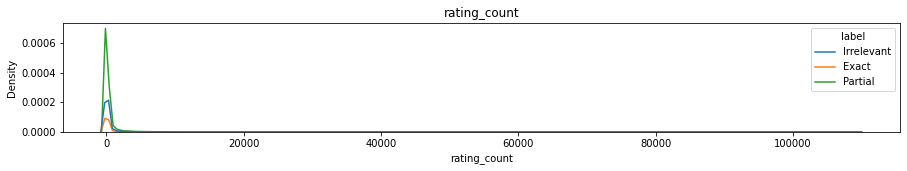

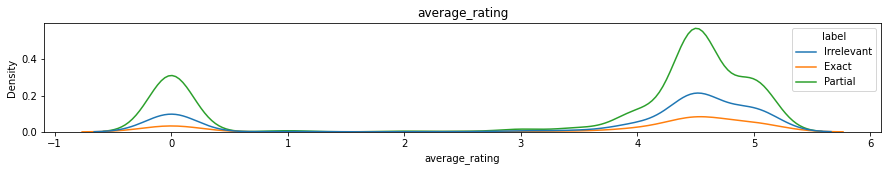

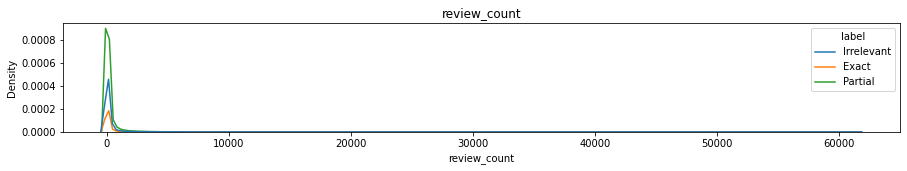

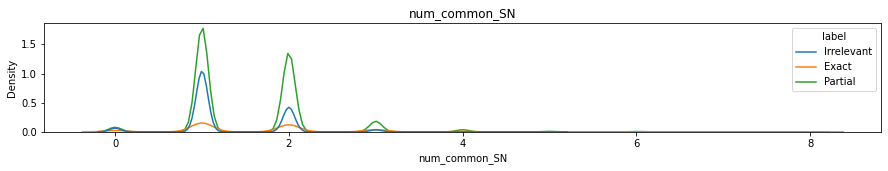

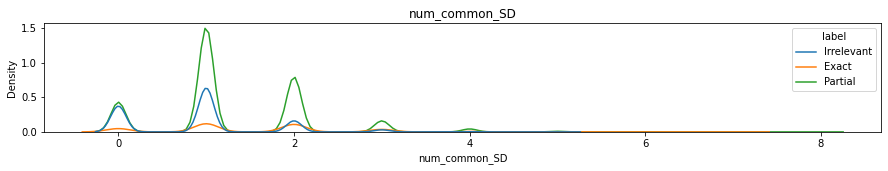

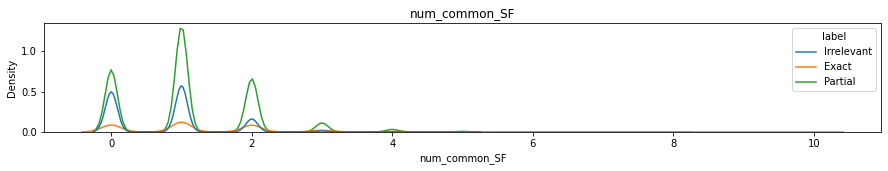

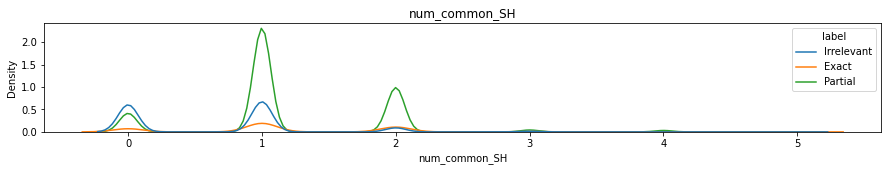

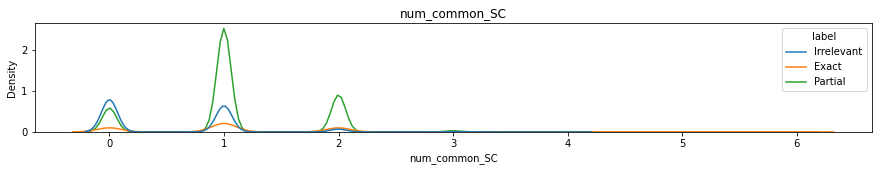

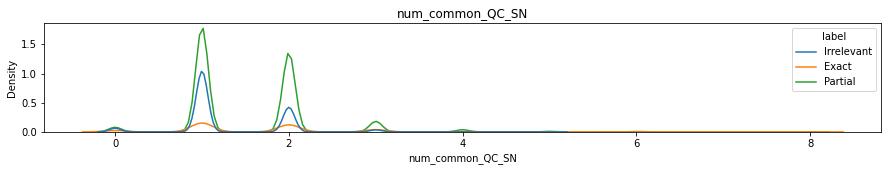

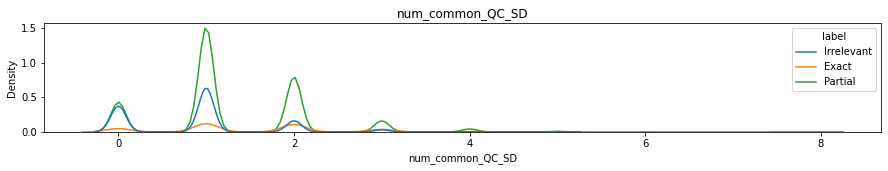

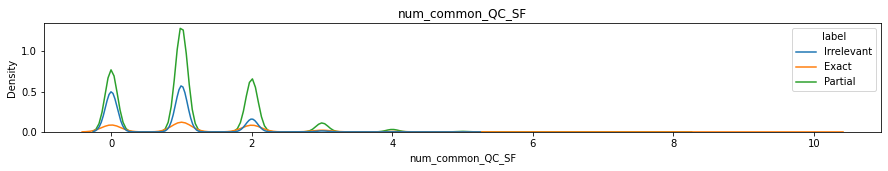

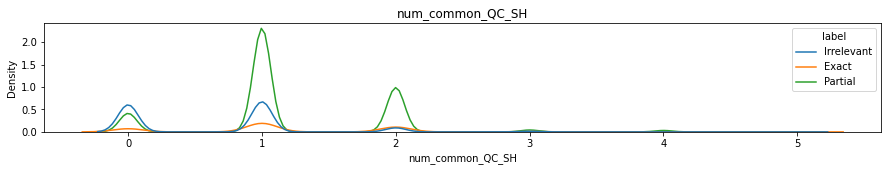

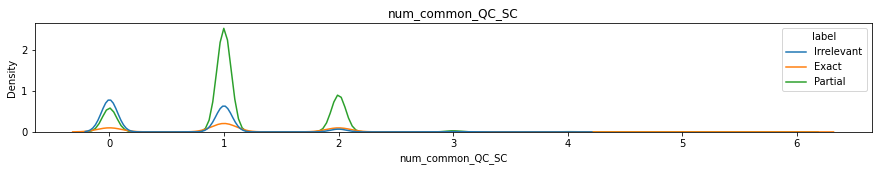

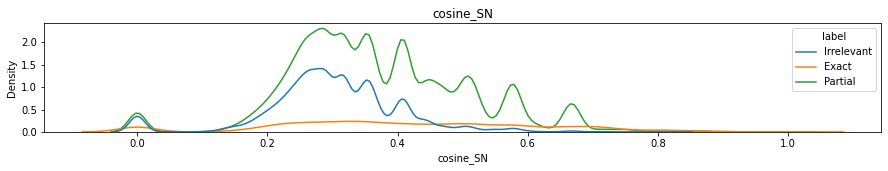

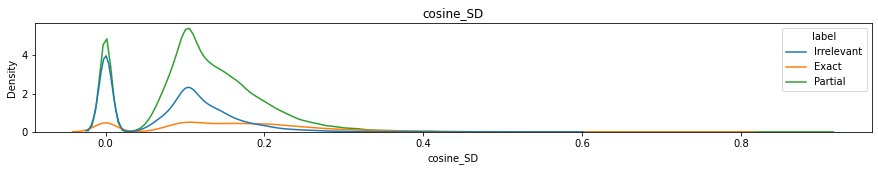

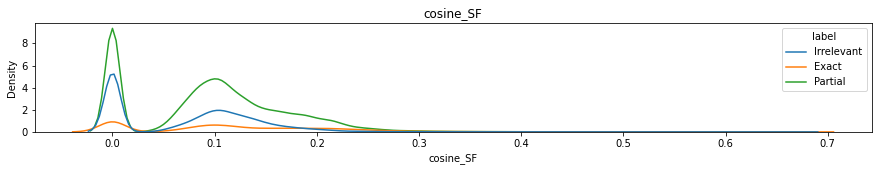

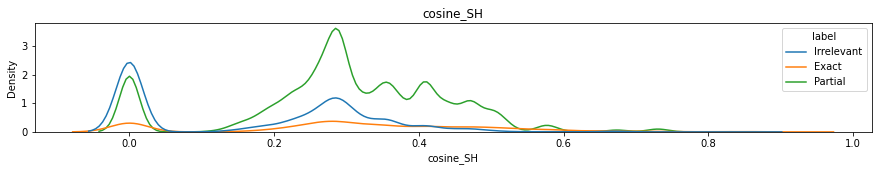

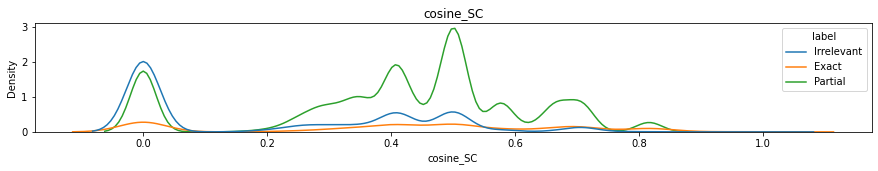

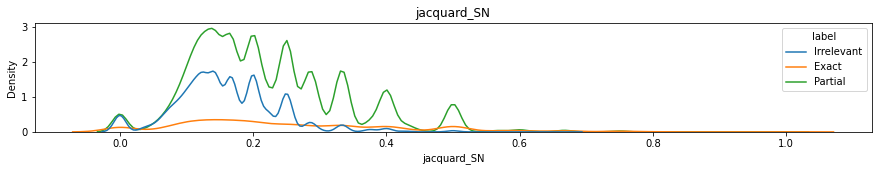

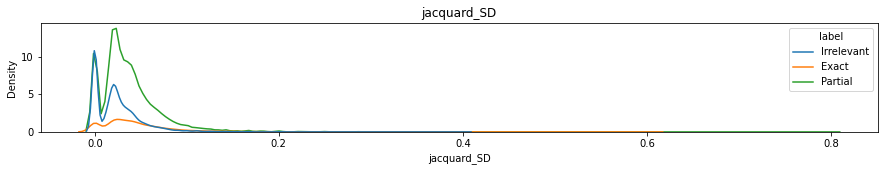

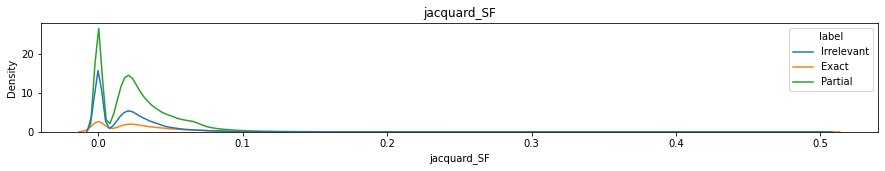

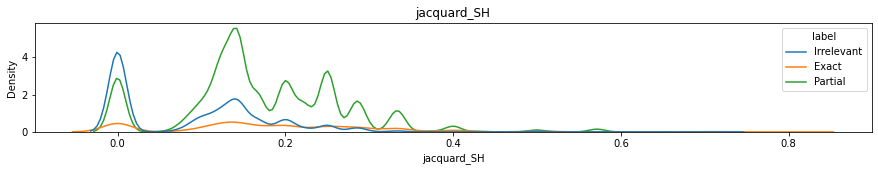

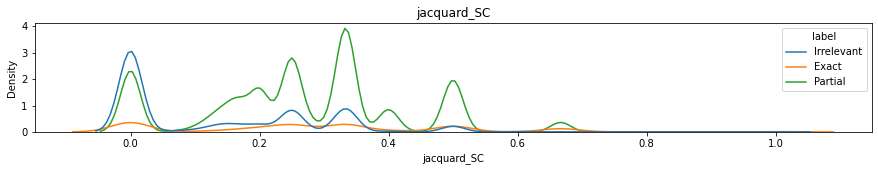

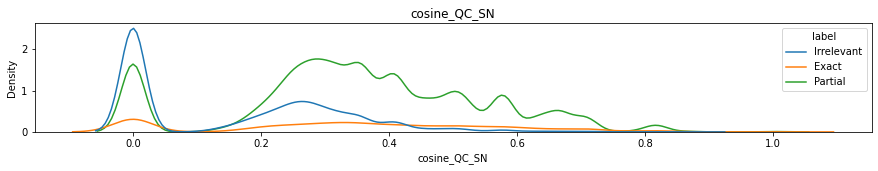

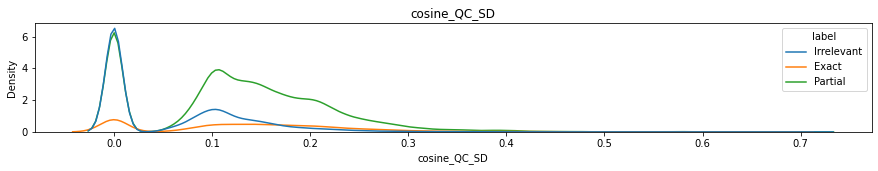

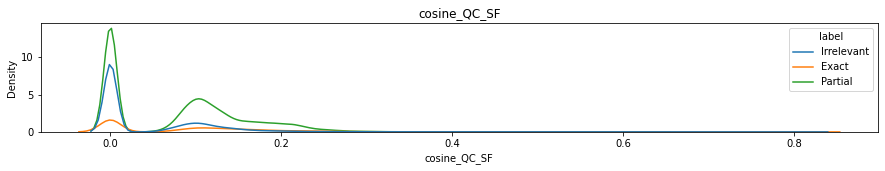

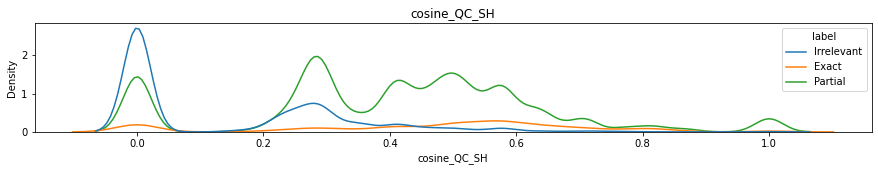

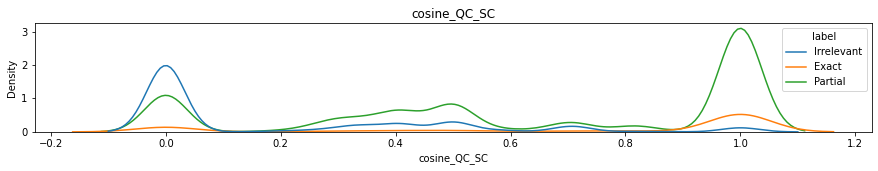

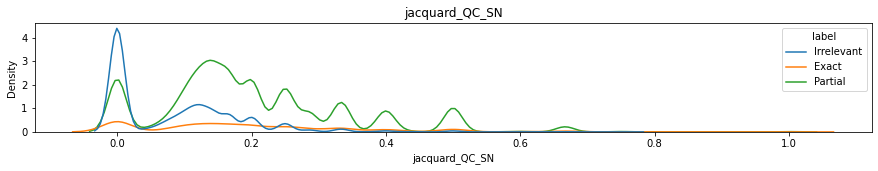

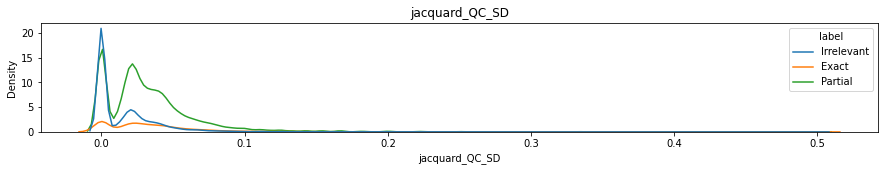

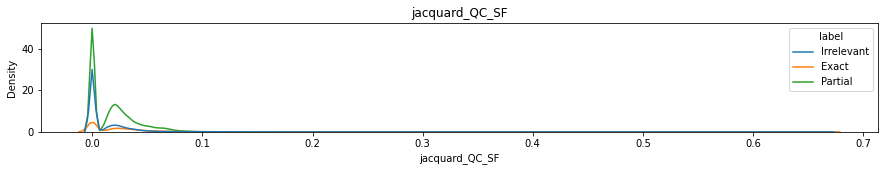

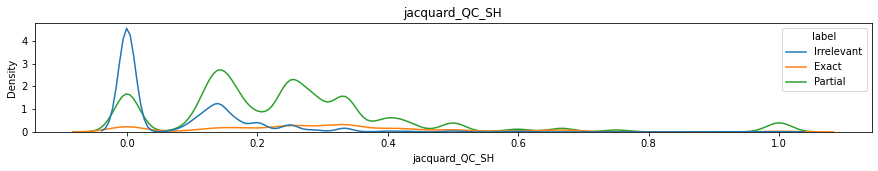

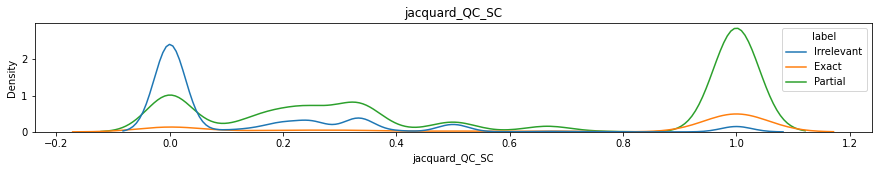

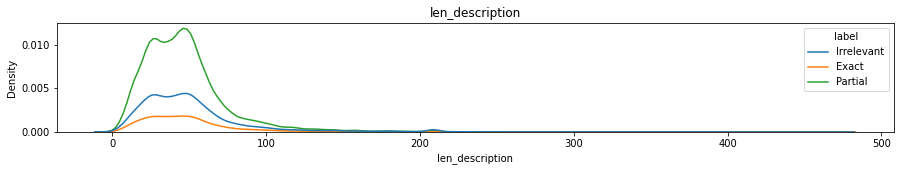

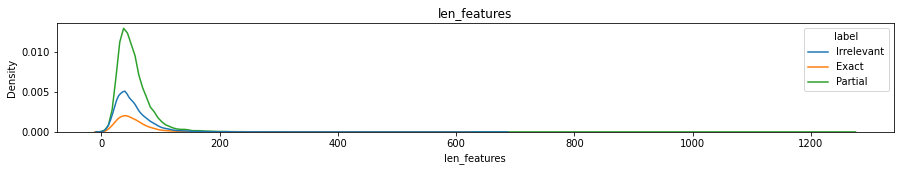

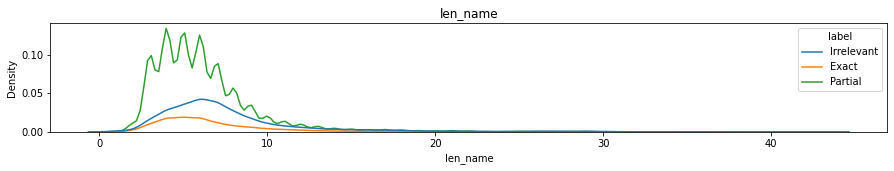

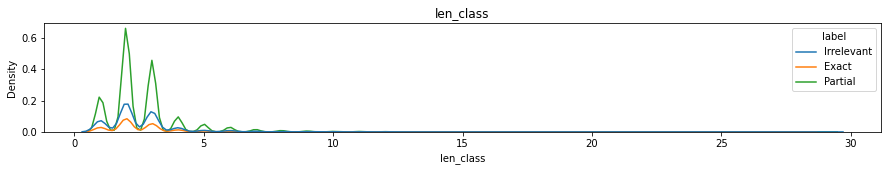

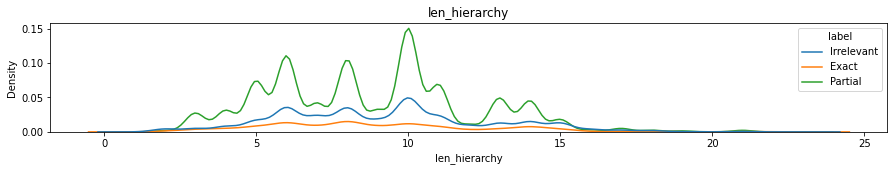

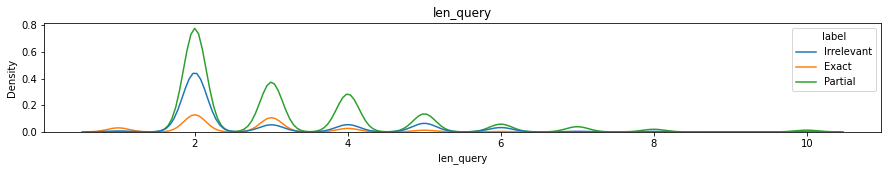

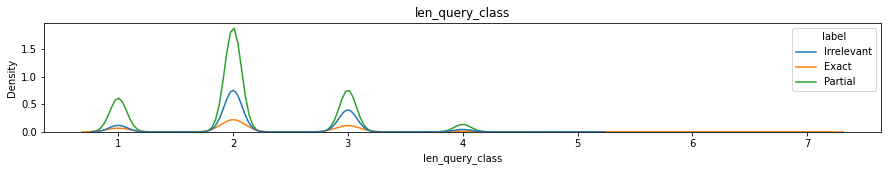

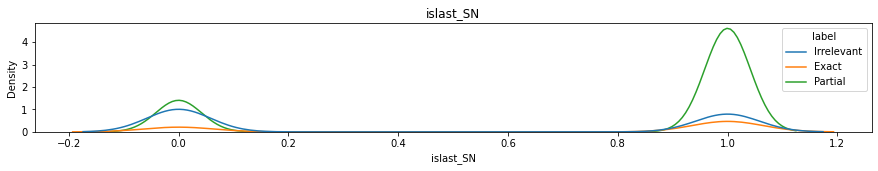

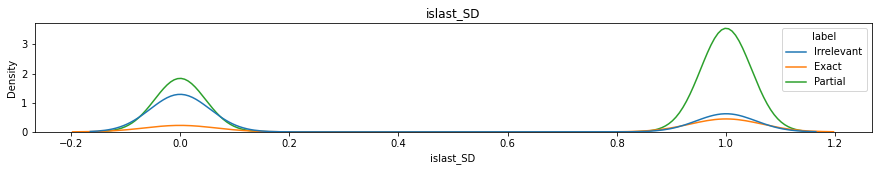

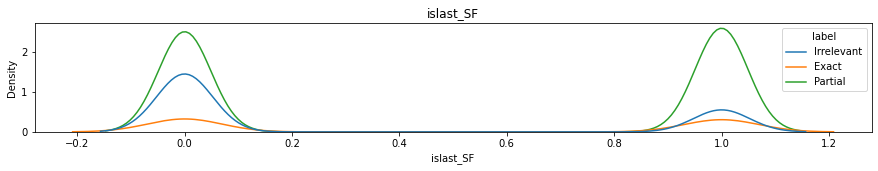

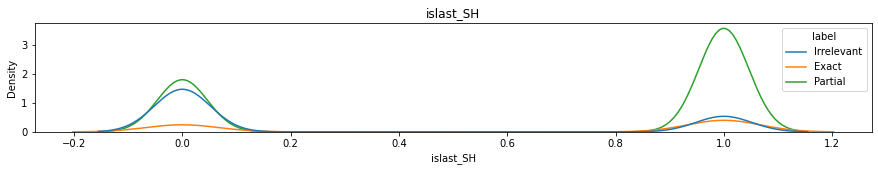

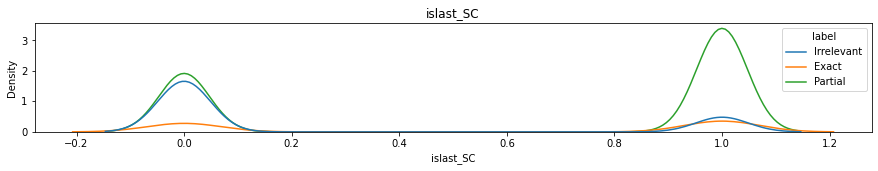

In [25]:
for col in feat_set1:
  plt.figure(figsize=(15,2))
  sns.kdeplot(data=eda_df1, x=col, hue="label")
  plt.title(col)
  plt.show()

Observations


*  Generally, in all the PDFs, we see that the curve for the positive or “Partial” class is above the "Irrelavant" or “Exact” class. This is plainly due to data imbalance as there are more points belonging to the “Partial” class than the “Exact” and "Irrelavant" .


*    You can see that at the mark 0, the curve for the Partial class is a little above Exact. As you move towards the right, the Partial curve still remains above but the ratio of the height of the Partial curve to the Exact curve increases. That is, as cosine_QC_SC( cosine similarity between query class and product class) increases, the ratio of points in the Partial class to the Exact class increases. Hence the probability of the point belonging to Partial class increases. Now if you give me two points, then I can say that the point having a larger value of cosine_QC_SC should have a higher relevance score., Same in case of Cosine_SC , Cosine_SN etc.Thus, from the above observation, we can conclude that cosine_SD does provide some information about the relevance score for a (search, product-text) pair.


*  Length features didn’t show a lot of difference in distributions.


*   One of the most interesting features was the islast feature. A pretty considerable difference in distribution was observed. For eg., in islast_ST the density of the Partial class seems to be similar at both 0 and 1 values but the density of the Exact class increases considerably from 0 to 1.



### CORRELATION MATRIX 

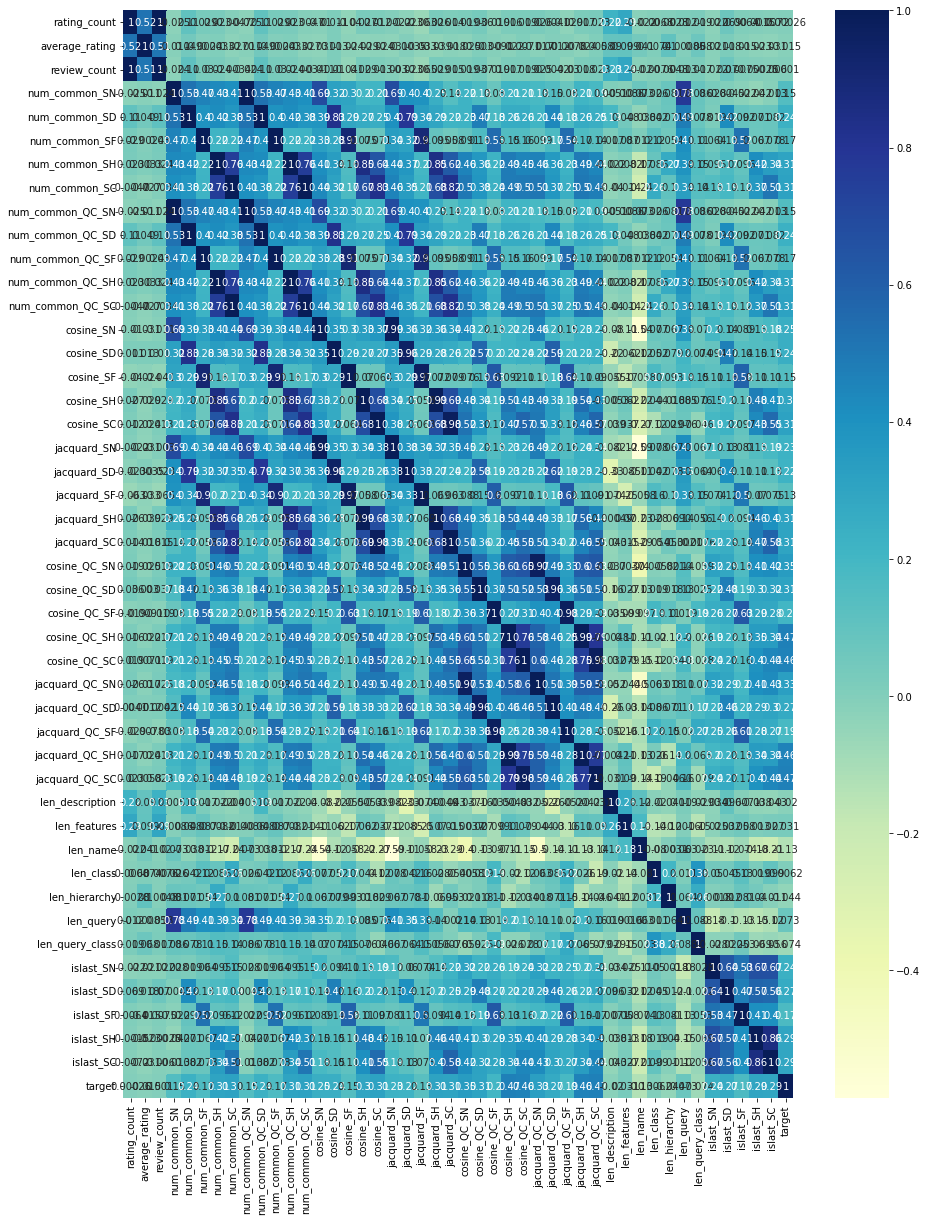

In [26]:


# plotting correlation heatmap
plt.figure(figsize=(15,20))
corr_df = eda_df.corr(method='spearman')
sns.heatmap(corr_df, cmap="YlGnBu", annot=True)  
plt.show()



In [27]:
thresh = 0.8
t1 = corr_df.abs()
t1 = t1.unstack()
T = t1.sort_values(kind="quicksort")
print('Features with correlation greater than {}'.format(thresh))
print(T[(T>thresh) & (T<1.0)].drop_duplicates())

Features with correlation greater than 0.8
jacquard_SC       num_common_SC       0.822365
num_common_SD     cosine_SD           0.828719
cosine_SC         num_common_QC_SC    0.829464
jacquard_SH       num_common_QC_SH    0.849971
num_common_SH     cosine_SH           0.852652
islast_SH         islast_SC           0.857694
jacquard_SF       num_common_QC_SF    0.899286
num_common_QC_SF  cosine_SF           0.907539
jacquard_SD       cosine_SD           0.955689
cosine_QC_SD      jacquard_QC_SD      0.959886
cosine_SF         jacquard_SF         0.967386
jacquard_QC_SN    cosine_QC_SN        0.972198
cosine_QC_SC      jacquard_QC_SC      0.976206
cosine_QC_SF      jacquard_QC_SF      0.980417
jacquard_SC       cosine_SC           0.980985
cosine_SN         jacquard_SN         0.986939
cosine_QC_SH      jacquard_QC_SH      0.987611
jacquard_SH       cosine_SH           0.989819
rating_count      review_count        0.997276
dtype: float64


There are a few highly correlated features. These correlated features can be redundant and hence we can try removing these highly correlated features.
We will omit them .

*rating_count,jacquard_SN,jacquard_SD,num_common_QC_SF,islast_SC,*
     




In [28]:
print('Most correlated features to relevance')
print('-'*50)
corr_df.abs()['target'].sort_values(ascending=False)

Most correlated features to relevance
--------------------------------------------------


target              1.000000
cosine_QC_SH        0.473173
jacquard_QC_SC      0.469354
cosine_QC_SC        0.461494
jacquard_QC_SH      0.461192
cosine_QC_SN        0.348711
jacquard_QC_SN      0.327959
num_common_QC_SC    0.314958
num_common_SC       0.314958
cosine_SC           0.313211
jacquard_SH         0.309692
cosine_QC_SD        0.306829
jacquard_SC         0.305452
num_common_SH       0.305117
num_common_QC_SH    0.305117
cosine_SH           0.296728
islast_SH           0.294881
islast_SC           0.292411
jacquard_QC_SD      0.272660
islast_SD           0.266617
cosine_SN           0.245380
cosine_SD           0.244711
islast_SN           0.239384
num_common_SD       0.237859
num_common_QC_SD    0.237859
jacquard_SN         0.228749
jacquard_SD         0.220586
cosine_QC_SF        0.203350
jacquard_QC_SF      0.187714
islast_SF           0.174324
num_common_SF       0.165361
num_common_QC_SF    0.165361
num_common_SN       0.149871
num_common_QC_SN    0.149871
cosine_SF     



*   

    The correlation scores are not very high but some correlation does exist.
    



*   We can see that correlation of 
cosine_QC_SH    ,
jacquard_QC_SC ,
cosine_QC_SC ,
jacquard_QC_SH   ,
cosine_QC_SN   ,
jacquard_QC_SN ,
num_common_QC_SC ,
num_common_SC   ,
cosine_SC     ,
jacquard_SH    
 are TOP 10




# Feature Set 2 - LSI similarity measures 

## FEATURES




*   Apply LSI on full text (combined name, class, hierarchy, features and description). Then, transform query and query class into the ‘concept’ space and calculate cosine similarity between them. Other similarity measure will be cosine coefficient, jacquard coefficient and inner product.





In [29]:
data2_tn = pd.read_excel(path+r'clean_df_train.xlsx')
data2_ts = pd.read_excel(path+r'clean_df_test.xlsx')


In [30]:
data2_tn = data2_tn.dropna().reset_index(drop=True)
data2_ts = data2_ts.dropna().reset_index(drop=True)

In [31]:
clean_df_train = data2_tn
clean_df_test = data2_ts

In [ ]:
combined_doc_tn = data2_tn["name"].astype(str) + ' ' + data2_tn["class"].astype(str)+ ' ' + data2_tn["hierarchy"].astype(str) + ' ' +data2_tn["description"].astype(str) + ' ' +data2_tn["features"].astype(str)

vectorizer = TfidfVectorizer(smooth_idf=True, max_features=2000, min_df=2)
X_combined_doc_tn = vectorizer.fit_transform(combined_doc_tn)
print(X_combined_doc_tn.shape) # check shape of the document-term matrix

# SVD represent documents and terms in vectors 
svd_model= TruncatedSVD(n_components=500, algorithm='randomized', n_iter=100, random_state=122)
svd_model.fit(X_combined_doc_tn)

tsvd_var_ratios = svd_model.explained_variance_ratio_
tsvd_var_ratios.sum()



(175085, 2000)


In [ ]:
truncated_combined_doc_tn = svd_model.transform(X_combined_doc_tn)
print(truncated_combined_doc_tn.shape)

X_search_tn = vectorizer.transform(data2_tn['query'])
print(X_search_tn.shape) # check shape of the document-term matrix

transformed_search_tn = svd_model.transform(X_search_tn)
print(transformed_search_tn.shape)



In [ ]:
import pickle
with open(path+r'\data\vectorizer.sav','wb') as f:
    pickle.dump( vectorizer,f)
with open(path+r'\data\svd_model.sav','wb') as f:
    pickle.dump( svd_model,f)

In [ ]:
combined_doc_ts = data2_ts["name"].astype(str) + ' ' + data2_ts["class"].astype(str)+ ' ' + data2_ts["hierarchy"].astype(str) + ' ' +data2_ts["description"].astype(str) + ' ' +data2_ts["features"].astype(str)


X_combined_doc_ts = vectorizer.transform(combined_doc_ts)
print(X_combined_doc_ts.shape) # check shape of the document-term matrix

# SVD represent documents and terms in vectors 


truncated_combined_doc_ts = svd_model.transform(X_combined_doc_ts)
print(truncated_combined_doc_ts.shape)

X_search_ts = vectorizer.transform(data2_ts['query'])
print(X_search_ts.shape) # check shape of the document-term matrix

transformed_search_ts = svd_model.transform(X_search_ts)
print(transformed_search_ts.shape)



Calculating similarity between them


In [ ]:
def cosine_similarity_vec(a, b):
  """
  Cosine Similarity between 2 vectors
  """  
  num = np.dot(a, b)
  den = norm(a)*norm(b)
  if den != 0:
    return num/den
  else:
    return 0

def jacquard_similarity_vec(a, b):
  """
  Cosine Similarity between 2 vectors
  """  
  num = np.dot(a,b)
  den = norm(a)**2 + norm(b)**2 - np.dot(a,b)
  if den != 0:
    return num/den
  else:
    return 0

def inner_product_vec(a, b):
  return np.dot(a,b)



In [ ]:
cos_sim = []
for i in range(len(transformed_search_tn)):
  cos_sim.append(cosine_similarity_vec(truncated_combined_doc_tn[i], transformed_search_tn[i]))
print(len(cos_sim))
data2_tn['lsi_cos_sim'] = cos_sim



In [ ]:
cos_sim = []
for i in range(len(transformed_search_ts)):
  cos_sim.append(cosine_similarity_vec(truncated_combined_doc_ts[i], transformed_search_ts[i]))
print(len(cos_sim))
data2_ts['lsi_cos_sim'] = cos_sim

In [ ]:

jaq_sim = []
for i in range(len(transformed_search_tn)):
  jaq_sim.append(jacquard_similarity_vec(truncated_combined_doc_tn[i], transformed_search_tn[i]))
print(len(jaq_sim))
data2_tn['lsi_jaq_sim'] = jaq_sim


In [ ]:

jaq_sim = []
for i in range(len(transformed_search_ts)):
  jaq_sim.append(jacquard_similarity_vec(truncated_combined_doc_ts[i], transformed_search_ts[i]))
print(len(jaq_sim))
data2_ts['lsi_jaq_sim'] = jaq_sim


In [ ]:

inn_prod = []
for i in range(len(transformed_search_tn)):
  inn_prod.append(inner_product_vec(truncated_combined_doc_tn[i], transformed_search_tn[i]))
print(len(inn_prod))
data2_tn['lsi_inn_prod'] = inn_prod

In [ ]:
inn_prod = []
for i in range(len(transformed_search_ts)):
  inn_prod.append(inner_product_vec(truncated_combined_doc_ts[i], transformed_search_ts[i]))
print(len(inn_prod))
data2_ts['lsi_inn_prod'] = inn_prod

In [ ]:

data2_tn = data2_tn[['lsi_cos_sim', 'lsi_jaq_sim',	'lsi_inn_prod']]
print(data2_tn.shape)
data2_tn.head(3)

In [ ]:
data2_tn.isnull().sum()

In [ ]:

eda_df2 = data2_tn
eda_df2['target'] = data1_tn['target']
# plotting correlation heatmap
corr_df = eda_df2[:4].corr(method='spearman')
plt.figure(figsize=(10,8))
sns.heatmap(corr_df, cmap="YlGnBu", annot=True)  
plt.show()

### Modeling 

In [ ]:

final_df = pd.concat([clean_df_train,data1_tn, data2_tn], axis=1, ignore_index=False)
final_df.head()

In [ ]:
X1 = final_df.drop(['id', 'query_id', 'product_id', 'label', 'name', 'class', 'description', 'features',
       'hierarchy', 'query', 'query_class', 'target','rating_count','jacquard_SN','jacquard_SD','num_common_QC_SF','islast_SC'], axis=1) 

Feature_columns = X1.columns

In [ ]:
 #tyre features
x = X1.values #returns a numpy array
# min_max_scaler = preprocessing.MinMaxScaler()
# x_scaled = min_max_scaler.fit_transform(x)
df = pd.DataFrame(x, columns=X1.columns)
X = df.values
y = final_df['target'].values 

#%%
'Split data for modeling¶'

from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.10, random_state=12)

print('Train values shape:', X_train.shape)
print('Val values shape:', X_val.shape)
print('Train target shape:', y_train.shape)
print('Val target shape:', y_val.shape)

In [ ]:
#%%'Plot feature importance of random forest classifier'
import seaborn as sns
def plot_feature_importance(importance,names,model_type):

    data={'feature_names':names,'feature_importance':importance}
    fi_df = pd.DataFrame(data)
    # tmu_Df = tmu_Df.sort_values(['ST'])
    #Sort the DataFrame in order decreasing feature importance
    fi_df.sort_values(['feature_importance'], ascending=False,inplace=True)
    fi_df=fi_df[:10]
    #Define size of bar plot
    plt.figure(figsize=(12,10))
    #Plot Searborn bar chart
    sns.barplot(x=fi_df['feature_importance'], y=fi_df['feature_names'])
    #Add chart labels
    plt.title(model_type + ' FEATURE IMPORTANCE')
    plt.xlabel('FEATURE IMPORTANCE')
    plt.ylabel('FEATURE NAMES')
    # plt.savefig(model_type+".JPEG")
    return fi_df

In [ ]:
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score,accuracy_score
import time

In [ ]:
xgb = XGBClassifier(random_state=25, n_estimators= 1500)



"k-fold stratified cross-validation"
n_splits = 3
stf = StratifiedKFold(n_splits=n_splits, random_state=5, shuffle=True)

accuracies = []

k=0
for trn_idx, val_idx in stf.split(X_train, y_train):
    print(k)
    x1, x2 = X_train[trn_idx], X_train[val_idx]
    y1, y2 = y_train[trn_idx], y_train[val_idx]
    xgbc = xgb.fit(x1, y1)
    Y_pred2 = xgbc.predict(x2)
    accuracies+=[round(accuracy_score(y2, Y_pred2),3)]
    k+=1

print('KS-Fold accuracies: ', accuracies)
print('Accuracy: (Mean - {}, Std - {})'.format(round(np.mean(accuracies),3), round(np.std(accuracies),3)))

"model fitting with full training data"
t_start = time.clock()
xgbc1 = xgb.fit(X_train, y_train)
t_end = time.clock()

t_diff = t_end - t_start
print('time taken for training in sec {}'.format(t_diff))
y_val_hat =xgbc1.predict(X_val)

y_train_hat=xgbc1.predict(X_train)

# y_train_hat=le.inverse_transform(y_train_hat)
# y_train=le.inverse_transform(y_train)
print('Train performance')
print('-------------------------------------------------------')
print(classification_report(y_train, y_train_hat))



print('Validation performance')
print('-------------------------------------------------------')
test_report= pd.DataFrame(classification_report(y_val,  y_val_hat, output_dict=True)).transpose()
print(test_report)

print('Confusion matrix')
print('-------------------------------------------------------')
cm=pd.DataFrame(confusion_matrix(y_val, y_val_hat))
print(cm)


In [ ]:
feature_importance=plot_feature_importance(xgbc1.feature_importances_,df.columns,'XGB')

### Evaluation

In [ ]:
final_df_ts = pd.concat([clean_df_test,data1_ts, data2_ts], axis=1, ignore_index=False)



In [ ]:
X_Test = final_df_ts[Feature_columns]  # features
# x = X1.values #returns a numpy array

Y_Test = final_df_ts['target']



In [ ]:
predictions = xgbc1.predict(X_Test)

print('Validation performance')
print('-------------------------------------------------------')
test_report= pd.DataFrame(classification_report(Y_Test,  predictions, output_dict=True)).transpose()
print(test_report)